## Portfolio Optimisation
#### March 2025

Nicholas Ballingall


In [3]:
# Import Libraries

import pandas as pd
import numpy as np
import cvxpy as cp
import random

import itertools
from itertools import product

import yfinance as yf
import riskfolio as rp # may need to pip install

import warnings # suppress a bunch of long-winded yfinance warnings
from warnings import simplefilter
simplefilter(action = "ignore", category = pd.errors.PerformanceWarning)

#NOTE: pip install PyPortfolioOpt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return
import arch
from arch import arch_model

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.tsa.tsatools import add_trend
from statsmodels.stats.outliers_influence import variance_inflation_factor as sm_vif
import scipy.optimize as sco

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns


### 1 – Import & Download Data

#### 1.1 – Stock Data

In [6]:
# Import Benchmark Data
"""
Factor Model Data 
Index holdings 
Filter listed country (US only) 
"""
local_path = '' # add local path here if needed

# Benchmark index data (Vanguard Information Technology)
vgt_raw = pd.read_excel(f'{local_path}/Holdings_details_Information_Technology_ETF.xlsx', header = 7)  # row 7 for headers
vgt_rows = vgt_raw.iloc[0:314, :] # adjusted for new header row
vgt = vgt_rows.loc[:, 'HOLDINGS':'SHARES']
vgt.drop(columns = 'SECURITYDEPOSITORYRECEIPTTYPE', inplace = True)
vgt = vgt[vgt['COUNTRY'] == 'US'] # remove non-US listings

# Make benchmark ticker list
tickers = vgt['TICKER'].tolist()
tickers = list(set(tickers))


In [7]:
# Stock Selection & Filtering
"""
Download stock adjusted close prices for vgt holdings
"""

# Required timespan
start_date = '2019-01-01'
end_date = '2024-12-21'

# dfs for stock data
stock_ret = pd.DataFrame()
log_ret = pd.DataFrame()

# Download prices
stock_data = yf.download(tickers,
                         start = start_date,
                         end = end_date,
                         interval = '1d',
                         auto_adjust = True,
                         group_by = 'ticker'
                        )

# Drop cols with NaN values (pricing data doesn't cover full timeframe)
stock_data.dropna(axis = 1, how = 'any', inplace = True)


[*********************100%***********************]  314 of 314 completed

2 Failed downloads:
['TWKS', 'ENV']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2024-12-21) (Yahoo error = "No data found, symbol may be delisted")')


In [8]:
# Filter illiquid stocks
"""
Drop stocks with trading volumes outwith 1std < average
"""

# Extract volume data – mean for individual stocks
stock_mean_vol = stock_data.xs('Volume', level = 1, axis = 1).mean() # adapted to work when df grouped by ticker

# Overall mean & std dev of volumes
pf_mean_vol = stock_mean_vol.mean() # mean vol for portfolio
pf_std_vol = stock_mean_vol.std() # std dev for portfolio

# Set volume threshold (1 std below mean)
vol_thresh = pf_mean_vol - pf_std_vol

# Filter out low volume stocks
liquid_stocks = stock_mean_vol[stock_mean_vol >= vol_thresh].index

# drop low volume stocks from main df
stock_data = stock_data.loc[:, liquid_stocks]


In [9]:
# Flatten Dataframe Index

stock_2df = stock_data.copy()
stock_2df.columns = [f'{stock} {col}' for stock, col in stock_2df.columns]


In [10]:
# Calculate Stock Returns
"""
Calculate daily arithmetic & log returns
"""

# List of tickers that were actually downlaoded
dl_tickers = stock_data.columns.get_level_values(0).unique()

# List of 'Close' cols in 2d dataframe
close_cols = [f'{ticker} Close' for ticker in dl_tickers]

# DF of just close prices
stock_close = stock_2df.loc[:, stock_2df.columns.isin(close_cols)]
stock_close.columns = [col.split()[0] for col in stock_close.columns] # remove 'Close' from col titles

# Create returns dfs
stock_ret = pd.DataFrame() # returns
stock_log = pd.DataFrame() # log returns

for ticker in dl_tickers:
    stock_ret[f'{ticker}'] = stock_close[f'{ticker}'].pct_change() # returns
    stock_log[f'{ticker}'] = np.log(stock_close[f'{ticker}'] / stock_close[f'{ticker}'].shift(1)) # log returns

# Drop NaN values
stock_ret.dropna(inplace = True)
stock_log.dropna(inplace = True)


In [11]:
# Augmented Dickey-Fuller Test
"""
Checks if log returns are stationary
"""

ns_data = [] # non-stationary columns list

# Define portfolio ADF function
def adfTest(df):

    # Run ADF test & track non-stationary df
    for column in df.columns:
        adf_result = adf(df[column])
        
        # Check if the p-value is greater than or equal to 0.05 (non-stationary)
        if adf_result[1] >= 0.05:
            ns_data.append(column)

    # Print the overall status of stationarity
    if len(ns_data) == 0:
        print('All data is stationary')
    
    elif len(ns_data) == len(df.columns):
        print('No data is stationary')
    
    else:
        print(f'{", ".join(ns_data)} are not stationary – dropped from DF')
        df.drop(columns = ns_data, inplace = True) # drop non-stationary columns

# Run ADF test
adfTest(stock_log)

# Keep columns in return dfs equal for better comparison
stock_ret.drop(columns = ns_data, inplace = True)


All data is stationary


#### 1.2 – US T-Bill Data 

*(Risk-Free Rate Proxy)*

In [13]:
# Calculate Risk-Free Rate
"""
Use short, med, & long term US T-bill yeilds as risk-free rate proxy (remember: US only stocks)
"""

# Use US T-bill yield indices
t_bills = ['^IRX', # 13-week
           '^FVX', # 5-year
           '^TNX' # 10-year
          ] 

# Download yeilds
tb_data = yf.download(t_bills,
                      start = start_date,
                      end = end_date,
                      interval = '1d',
                      auto_adjust = True,
                      group_by = 't_bill'
                     )

# Drop NaNs
tb_data.dropna(axis = 1, how = 'any', inplace = True)

# Flatten df & keep only 'close' columns (same process ran on stock_data)
tb_2df = tb_data.copy()
tb_2df.columns = [f'{t_bill} {col}' for t_bill, col in tb_2df.columns]

tb_close_cols = [f'{t_bill} Close' for t_bill in t_bills]
tb_yield = tb_2df.loc[:, tb_2df.columns.isin(tb_close_cols)]
tb_yield.columns = [col.split()[0] for col in tb_yield.columns]

# Annualised risk-free rates
a_rfr = tb_yield.rename(columns = {'^IRX': 'ST RFR', '^FVX': 'MT RFR', '^TNX': 'LT RFR'}) # clearer names

# Calculate daily yield rates ('de-annualise' data)
d_rfr = pd.DataFrame(index = a_rfr.index)
d_rfr = ((1 + a_rfr / 100) ** (1 / 252)) - 1 # 252 trading days per year

# Calculate log rfr for use with log stock returns
for rate in d_rfr:
    d_rfr[f'{rate} (log)'] = np.log(1 + d_rfr[rate])

# Single-number rates (daily)
st_rfr = d_rfr['ST RFR'].mean() # short-term
mt_rfr = d_rfr['MT RFR'].mean() # medium-term
lt_rfr = d_rfr['LT RFR'].mean() # long-term


[*********************100%***********************]  3 of 3 completed


### 2 – Factor Modelling

#### 2.1 – Import & Define Factor Data

In [16]:
# Fundemental Factor Modelling
"""
FF5 Model
Carhart Model
Augmented 6 Factor Model (FF5 + MOM)
"""

# Import Factor Data

# FF5
factors = pd.read_csv(f'{local_path}/F-F_Research_Data_5_factors_2x3_daily.csv', skiprows = 3)
factors.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']  # rename columns

# Fix date index (FF5)
factors = factors.dropna(subset = ['Date'])  # drop NaN
factors['Date'] = factors['Date'].astype(str)  # convert to string
factors = factors[factors['Date'].str.isnumeric()]  # ensure numeric values
factors['Date'] = pd.to_datetime(factors['Date'], format = '%Y%m%d')  # convert to datetime
factors.set_index('Date', inplace = True)  # set date as index


# Momentum
mom_data = pd.read_csv(f'{local_path}/F-F_Momentum_Factor_daily.csv', skiprows = 13)
mom_data.columns = ['Date', 'MOM']  # rename columns

# Fix date index (momentum)
mom_data = mom_data.dropna(subset = ['Date'])
mom_data['Date'] = mom_data['Date'].astype(str)
mom_data = mom_data[mom_data['Date'].str.isnumeric()]
mom_data['Date'] = pd.to_datetime(mom_data['Date'], format = '%Y%m%d')
mom_data.set_index('Date', inplace = True)


# Merge dataframes
factors = factors.merge(mom_data, how = 'inner', left_index = True, right_index = True)

# Filter df for dates in portfolio data
factors = factors[factors.index.isin(stock_ret.index)]


In [17]:
# Alternative Factor Modelling
"""
q-Factor
Sentiment shocks (custom factor)
"""

# Import q-Factor Data
q_data = pd.read_csv(f'{local_path}/q5_factors_daily_2024.csv')
q_data.columns = ['Date', 'RF', 'MKT-R', 'ME-R', 'IA-R', 'ROE-R', 'EG-R']  # rename columns

# Fix date index
q_data = q_data.dropna(subset = ['Date'])  # drop NaN
q_data['Date'] = q_data['Date'].astype(str)  # convert to string
q_data = q_data[q_data['Date'].str.isnumeric()]  # ensure numeric values
q_data['Date'] = pd.to_datetime(q_data['Date'], format = '%Y%m%d')  # convert to datetime
q_data.set_index('Date', inplace = True)  # set date as index


# Filter df for dates in portfolio data
q_data = q_data[q_data.index.isin(stock_ret.index)]
q_data = q_data.drop(columns = ['RF'], axis = 1) # drop rfr & excess return cols, as alreayd accounted for in xs_ret


In [18]:
# Create Sentiment Shock Factor
"""
log of VIX data captures sentiment shocks
Residuals from VIX linear regression captures unexpected sentiment volatility
"""

sentiment_tickers = ['^VIX'] # only VIX for now. Written to be scalable

# Download sentiment data
sentiment_data = yf.download(sentiment_tickers,
                       start = start_date,
                       end = end_date,
                       interval = '1d',
                       auto_adjust = True,
                       group_by = 'ticker'
                      )

sentiment_data.dropna(axis = 1, how = 'any', inplace = True) # drop NaNs                       
sentiment_2df = sentiment_data.copy()
sentiment_2df.columns = [f'{ticker} {col}' for ticker, col in sentiment_2df.columns]

sentiment_close_cols = [f'{ticker} Close' for ticker in sentiment_tickers]
sentiment_df = sentiment_2df.loc[:, sentiment_2df.columns.isin(sentiment_close_cols)]
sentiment_df.columns = [col.split()[0] for col in sentiment_df.columns]


# Sentiment Factor DataFrame
sentiment_df['^VIX (log)'] = np.log(sentiment_df['^VIX']).diff() # senitment shocks
model = sm.OLS(sentiment_df['^VIX'].diff().dropna(), add_trend(sentiment_df['^VIX'].shift(1).dropna(), trend = 'c'))
residuals = model.fit().resid
sentiment_df['VIX Residuals'] = residuals # unexpected sentiment volatility

# Drop unneeded columns
sentiment_df = sentiment_df.dropna()
sentiment_df.columns = ['VIX', 'VIX (log)', 'VIX Residuals']  # rename columns


[*********************100%***********************]  1 of 1 completed
/var/folders/05/gww8vx014vx4j1fbdxvrjm100000gn/T/ipykernel_3086/2517802137.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['^VIX (log)'] = np.log(sentiment_df['^VIX']).diff() # senitment shocks
/var/folders/05/gww8vx014vx4j1fbdxvrjm100000gn/T/ipykernel_3086/2517802137.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['VIX Residuals'] = residuals # unexpected sentiment volatility


#### 2.2 – Prepare Factor Models

In [20]:
# Function to Run Models
"""
Runs linear regression, stores metrics
Function can print all OLS outputs or the average figures (user input decies)
Limit 'top stocks' to 15 here, based on adjusted R-squared
"""

def factorModel(df, X_factors, model_name, results = False, summary = False, num_top_stocks = 15):
    r2_scores = {}
    adj_r2_scores = {}

    # Store model summary stats
    coeffs = []
    t_values = []
    p_values = []
    r2_vals = []
    adj_r2_vals = []

    for ticker in stock_ret.columns: # loop through all stocks
        y = df[ticker]
        X = df[X_factors] # factor model data
        X = sm.add_constant(X) # intercept

        model = sm.OLS(y, X).fit() # regression
        r2_scores[ticker] = model.rsquared # store R-squared
        adj_r2_scores[ticker] = model.rsquared_adj # store adj R-squared

        # Store coefficients and statistics
        coeffs.append(model.params)
        t_values.append(model.tvalues)
        p_values.append(model.pvalues)
        r2_vals.append(model.rsquared)
        adj_r2_vals.append(model.rsquared_adj)

        if results == True:
            print(f'*** {model_name} ***\n')
            print(model.summary())
        else:
            continue

    if summary == True:
        avg_coeffs = pd.DataFrame(coeffs).mean()
        avg_t_values = pd.DataFrame(t_values).mean()
        avg_p_values = pd.DataFrame(p_values).mean()
        avg_r2 = np.mean(r2_vals)
        avg_adj_r2 = np.mean(adj_r2_vals)

        print(f'\n*** {model_name} - Average Regression Summary ***\n')
        print(f'R-squared: {avg_r2:.4f}')
        print(f'Adjusted R-squared: {avg_adj_r2:.4f}')
        #print('\nAverage Coefficients:')
        #print(avg_coeffs)
        #print('\nAverage t-values:')
        #print(avg_t_values)
        print('\nAverage p-values:') # isolate p-values for comparison
        print(avg_p_values)

    # Pull stocks with highest adj R-squared scores
    top_stocks = sorted(adj_r2_scores, key = adj_r2_scores.get, reverse = True)[:num_top_stocks]

    return pd.DataFrame({'Ticker': top_stocks, 'Adj R-squared': [adj_r2_scores[s] for s in top_stocks]})
    

In [21]:
# Aligned & Combined DF of Portfolio Excess Returns & Factor Data


factor_df = (
    stock_ret # portfolio excess returns
    .merge(factors, how = 'inner', left_index = True, right_index = True) # fundemental factors
    .merge(q_data, how = 'inner', left_index = True, right_index = True) # growth factors
    .merge(sentiment_df, how = 'inner', left_index = True, right_index = True) # sentiment factors
    .merge(d_rfr, how = 'inner', left_index = True, right_index = True) # daily risk-free rates
)


In [22]:
# Set Model Factors
    # note: reformat for better clarity into each factor's purpose
"""
Dropped default risk-free rates in favour of being concistent with T-bill proxy throughout analysis
Default to medium-term rfr (5-years)
"""

# Fundemental Factors
ff5_factors = ['SMB', 'HML', 'RMW', 'CMA', 'MT RFR'] # exclude 'Mkt-RF' as running models on excess returns
crht_factors = ['SMB', 'HML', 'MOM', 'MT RFR']
asf_factors = ['SMB', 'HML', 'RMW', 'CMA', 'MOM', 'MT RFR'] # 'augmented six factor'

# Alternative Factors
q_factors = ['MKT-R', 'ME-R', 'IA-R', 'ROE-R', 'EG-R', 'MT RFR'] # size, investment, return on equity, expected growth
sentiment_factors = ['VIX (log)', 'VIX Residuals', 'MT RFR'] # Residuals – unexpected volatility, Log – senitment shocks

# All RFR factors
rfr_factors = ['ST RFR', 'MT RFR', 'LT RFR']


#### 2.3 – Run Factor Models

In [24]:
# Run Factor Models

# Fundemental Factors
ff5_stocks = factorModel(factor_df, ff5_factors, 'FF5') # Fama-French Five-Factor
crht_stocks = factorModel(factor_df, crht_factors, 'CRHT') # Carhart
asf_stocks = factorModel(factor_df, asf_factors, 'ASF') # Augmented Six-Factor Model (FF5 + Carhart)

# Alternative Factors
q_stocks = factorModel(factor_df, q_factors, 'q_model') # q-Factor
sentiment_stocks = factorModel(factor_df, sentiment_factors, 'Sentiment') # Market Sentiment


In [25]:
# Create Combined Results DF

# Dictionary to handle multi-level indexing (df > dict. > df probs isn't great. Fix later)
ff5_stocks.columns = pd.MultiIndex.from_product([['FF5'], ff5_stocks.columns])
crht_stocks.columns = pd.MultiIndex.from_product([['CRHT'], crht_stocks.columns])
asf_stocks.columns = pd.MultiIndex.from_product([['ASF'], asf_stocks.columns])
q_stocks.columns = pd.MultiIndex.from_product([['q-Factor'], q_stocks.columns])
sentiment_stocks.columns = pd.MultiIndex.from_product([['Sentiment'], sentiment_stocks.columns])

# Concatenate dfs
factor_stocks = pd.concat([ff5_stocks, crht_stocks, asf_stocks, q_stocks, sentiment_stocks], axis = 1)

# Set proper multi-index column names
factor_stocks.columns = pd.MultiIndex.from_tuples(factor_stocks.columns)

factor_stocks = factor_stocks.round(4) # 4dp
factor_stocks


FF5                 CRHT                  ASF               q-Factor  \
   Ticker Adj R-squared Ticker Adj R-squared Ticker Adj R-squared   Ticker   
0     MDB        0.3482   TEAM        0.2466    MDB        0.3478     MSFT   
1    TEAM        0.3344    MDB        0.2390   TEAM        0.3415      APH   
2    HUBS        0.3326   OKTA        0.2388   TWLO        0.3340     AAPL   
3    TWLO        0.3290    RNG        0.2385   HUBS        0.3338     INTU   
4    OKTA        0.3229    BHE        0.2374   OKTA        0.3229      TEL   
5    SMAR        0.3083     WK        0.2371   SMAR        0.3094     ANSS   
6    ESTC        0.3037   DOCU        0.2364   ESTC        0.3087     CDNS   
7      ZS        0.2990   TWLO        0.2327   DOCU        0.3020     SNPS   
8    DOCU        0.2961     ZS        0.2312    RNG        0.3013      TXN   
9      WK        0.2954    CXT        0.2305     ZS        0.2990      VSH   
10   VRNS        0.2868   PLXS        0.2282     WK        0.2961      CXT   
11    RNG        0.2864   SMAR        0.2257   VRNS        0.2871      ADI   
12    NOW        0.2813   ESTC        0.2252    NOW        0.2812     ADBE   
13   FIVN        0.2777    PRO        0.2236   FIVN        0.2777     MCHP   
14   QTWO        0.2709   HUBS        0.2187    PRO        0.2738     ADSK   

                 Sentiment                
   Adj R-squared    Ticker Adj R-squared  
0         0.7726       APH        0.4264  
1         0.6762      MSFT        0.3971  
2         0.6651       TXN        0.3636  
3         0.6636      MCHP        0.3634  
4         0.6539       ADI        0.3566  
5         0.6539      ANSS        0.3494  
6         0.6351      AAPL        0.3401  
7         0.6284       VSH        0.3352  
8         0.6100       CDW        0.3335  
9         0.6036       TEL        0.3310  
10        0.6002      AMAT        0.3253  
11        0.5980      ASGN        0.3241  
12        0.5938      CDNS        0.3236  
13        0.5936       ACN        0.3212  
14        0.5912      SNPS        0.3172

#### 2.4 – Optimised Factor Model

In [27]:
# Refine Factor Model
"""
Analyse the effectiveness of each factor and its contribution to the model
note: p-values > 0.05 unlikely to be significant
"""

# List all factors
all_factors = ff5_factors + crht_factors + asf_factors + q_factors + sentiment_factors + rfr_factors
all_factors = list(dict.fromkeys(all_factors)) # eliminate duplicate items

# Run model with all factors
all_stocks = factorModel(factor_df, all_factors, 'All Factors Test', summary = True) # Fama-French Five-Factor




*** All Factors Test - Average Regression Summary ***

R-squared: 0.4191
Adjusted R-squared: 0.4132

Average p-values:
const            0.551802
SMB              0.243555
HML              0.206144
RMW              0.260965
CMA              0.413133
MT RFR           0.507095
MOM              0.345205
MKT-R            0.000518
ME-R             0.323384
IA-R             0.309017
ROE-R            0.337822
EG-R             0.194504
VIX (log)        0.251098
VIX Residuals    0.247180
ST RFR           0.552423
LT RFR           0.529215
dtype: float64


In [28]:
# Check Factor Multicollinearity (Variance Inflation Factor)
"""
VIF > 5 – moderate multicollinearity 
VIF > 10 – strong multicollinearity (potential overfitting)
"""

def runVif(df):
    X = sm.add_constant(df)
    vif_data = pd.DataFrame()
    vif_data['Factor'] = X.columns
    vif_data['VIF'] = [sm_vif(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_test = runVif(factor_df[all_factors])
vif_test
    

Factor        VIF
0           const  17.160422
1             SMB  25.378546
2             HML   3.370355
3             RMW   2.980357
4             CMA   7.048589
5          MT RFR  72.944313
6             MOM   2.081365
7           MKT-R   2.850715
8            ME-R  21.919184
9            IA-R   8.312890
10          ROE-R   5.372457
11           EG-R   3.622289
12      VIX (log)   5.953107
13  VIX Residuals   7.240705
14         ST RFR   8.711192
15         LT RFR  69.318944

In [29]:
# Iteratively Remove Factors w/ High Multicollonearity
"""
Drop factors with VIF >5
Works iteratively, dropping highest VIF factor each time until all factors <5 VIF
"""

def iterVif(df, threshold = 5.0):

    X = df.copy()  # avoid modifying original dataframe

    while True:
        vif_data = runVif(X)  # VIF test
        vif_data = vif_data[vif_data['Factor'] != 'const']  # exclude intercept
        
        max_vif = vif_data.loc[vif_data['VIF'].idxmax()]  #find the highest VIF

        if max_vif['VIF'] < threshold:
            break  # Stop if all VIFs are below the threshold
        
        print(f'Dropping {max_vif["Factor"]} with VIF {max_vif["VIF"]:.2f}')
        X = X.drop(columns = [max_vif['Factor']])

    return X.columns.tolist()  # return reduced df

# Run function
vif_factors = iterVif(factor_df[all_factors])
vif_factors


Dropping MT RFR with VIF 72.94
Dropping SMB with VIF 25.37
Dropping LT RFR with VIF 8.20
Dropping IA-R with VIF 8.05
Dropping VIX Residuals with VIF 6.97


['HML',
 'RMW',
 'CMA',
 'MOM',
 'MKT-R',
 'ME-R',
 'ROE-R',
 'EG-R',
 'VIX (log)',
 'ST RFR']

In [30]:
# Run model with VIF factors
"""
Run regression model again, with all remaining factors after iterative VIF
"""
vif_stocks = factorModel(factor_df, vif_factors, 'VIF Factors Test', summary = True) # Fama-French Five-Factor



*** VIF Factors Test - Average Regression Summary ***

R-squared: 0.4123
Adjusted R-squared: 0.4084

Average p-values:
const        0.494205
HML          0.158667
RMW          0.231867
CMA          0.270881
MOM          0.324503
MKT-R        0.000365
ME-R         0.054176
ROE-R        0.247420
EG-R         0.181765
VIX (log)    0.379710
ST RFR       0.522592
dtype: float64


In [31]:
# Experimental Factor Models

"""
Loop through all combos of statistically significant facfors (~p-value < 0.05)
Return 5 models with highest average adj R-squared scores, and the top 15 stocks for each model


NOTE: risk-free rate doesn't seem to be a signficiant factor here. Maybe due to
tech (growth) stock investors being signficantly less risk-averse than value investors?
"""
# Loop through all combinations of 'clean factors'

# Clean factors
clean_factors = ['ME-R', 'MKT-R', 'ST RFR', 'VIX (log)'] # inc. rfr & VIX (log) for testing (high p-vals)

model_results = {} # dictionary of results

for r in range(1, len(clean_factors) + 1):  # r = 1 to len(clean_factors)
    for combo in itertools.combinations(clean_factors, r):
        model_name = ' + '.join(combo)  # create a name for the model
        model_results[model_name] = factorModel(factor_df, list(combo), model_name)



# Extract Top-Performning Experimental Models

num_models = 5 # number of top-performing models to extract

# Calculate average R-squared score per run
avg_r2 = {factor: df['Adj R-squared'].mean() for factor, df in model_results.items()}

# Sort by avg R-squared; extract top 5 results
top_models_dict = sorted(avg_r2.items(), key = lambda x: x[1], reverse = True)[:num_models] # [:5] extracts five models

# Extract top models' dataframes
top_models = {factor: model_results[factor] for factor, _ in top_models_dict}

# Concatenate dfs
exp_models = pd.concat(top_models, names = ['Factor Combination'])


# Improve DF Formatting & Legibility

# Factor combo mapping dictionary
model_names = {factor: f'Model {i+1}' for i, (factor, _) in enumerate(top_models_dict)}
exp_models = exp_models.rename(index =  model_names) # apply names to df
exp_models = exp_models.reset_index().rename(columns={'Factor Combination': 'Model Name'}) # reset index
exp_models_long = exp_models.copy() # backup in case formatting causes isses

# Convert df to wide-format
model_frames = {} # dictionary of formatted data for models

# Iteratively re-format dfs
for model_name, df in exp_models.groupby('Model Name'):
    df = df.reset_index(drop = True)  # ensure numeric index
    model_frames[model_name] = df.set_index(pd.Index(df.index))  # maintain proper row alignment

# Concatenate along columns – multi-index on the x-axis
exp_models = pd.concat(model_frames, axis = 1)

exp_models = exp_models.drop(columns = ['level_1', 'Model Name'], level = 1) # drop unneeded columns


display(model_names) # model names

display(exp_models)


{'ME-R + MKT-R + VIX (log)': 'Model 1',
 'ME-R + MKT-R + ST RFR + VIX (log)': 'Model 2',
 'ME-R + MKT-R': 'Model 3',
 'ME-R + MKT-R + ST RFR': 'Model 4',
 'MKT-R + VIX (log)': 'Model 5'}

Model 1               Model 2               Model 3               Model 4  \
    Ticker Adj R-squared  Ticker Adj R-squared  Ticker Adj R-squared  Ticker   
0     MSFT      0.723587    MSFT      0.723447    MSFT      0.723734    MSFT   
1      APH      0.675062     APH      0.675035     APH      0.672241     APH   
2      TEL      0.652867     TEL      0.652666     TEL      0.652774     TEL   
3     AAPL      0.633709    AAPL      0.633798    AAPL      0.633937    AAPL   
4     INTU      0.620105    INTU      0.619871    INTU      0.618848    INTU   
5      VSH      0.599545     VSH      0.599301     VSH      0.598776     VSH   
6     ANSS      0.599362    ANSS      0.599094    ANSS      0.598395    ANSS   
7      TXN      0.593134     TXN      0.592939     TXN      0.591432     TXN   
8      ADI      0.588327     ADI      0.588054     ADI      0.586994     ADI   
9      ACN      0.587052     ACN      0.586911     ACN      0.586498     ACN   
10    MCHP      0.582226    MCHP      0.582189    MCHP      0.580671    MCHP   
11    LFUS      0.570627    LFUS      0.570432    LFUS      0.570687    LFUS   
12     ARW      0.567536     ARW      0.567417     ARW      0.567387     ARW   
13    CDNS      0.564849    CDNS      0.564718    CDNS      0.563181    CDNS   
14    NXPI      0.557396    SNPS      0.557243    NXPI      0.557105    NXPI   

                 Model 5                
   Adj R-squared  Ticker Adj R-squared  
0       0.723594     APH      0.670312  
1       0.672219    MSFT      0.657752  
2       0.652574     TEL      0.613687  
3       0.634027    AAPL      0.601211  
4       0.618615     TXN      0.593383  
5       0.598530    INTU      0.593337  
6       0.598127     ADI      0.585717  
7       0.591234     ACN      0.583896  
8       0.586720    ANSS      0.579166  
9       0.586359    MCHP      0.576230  
10      0.580627    KLAC      0.552403  
11      0.570491    AMAT      0.551402  
12      0.567270    SWKS      0.542312  
13      0.563044    ADSK      0.541476  
14      0.556816    CDNS      0.539634

Lowest Avg Correlation: Model 2 (0.6573)


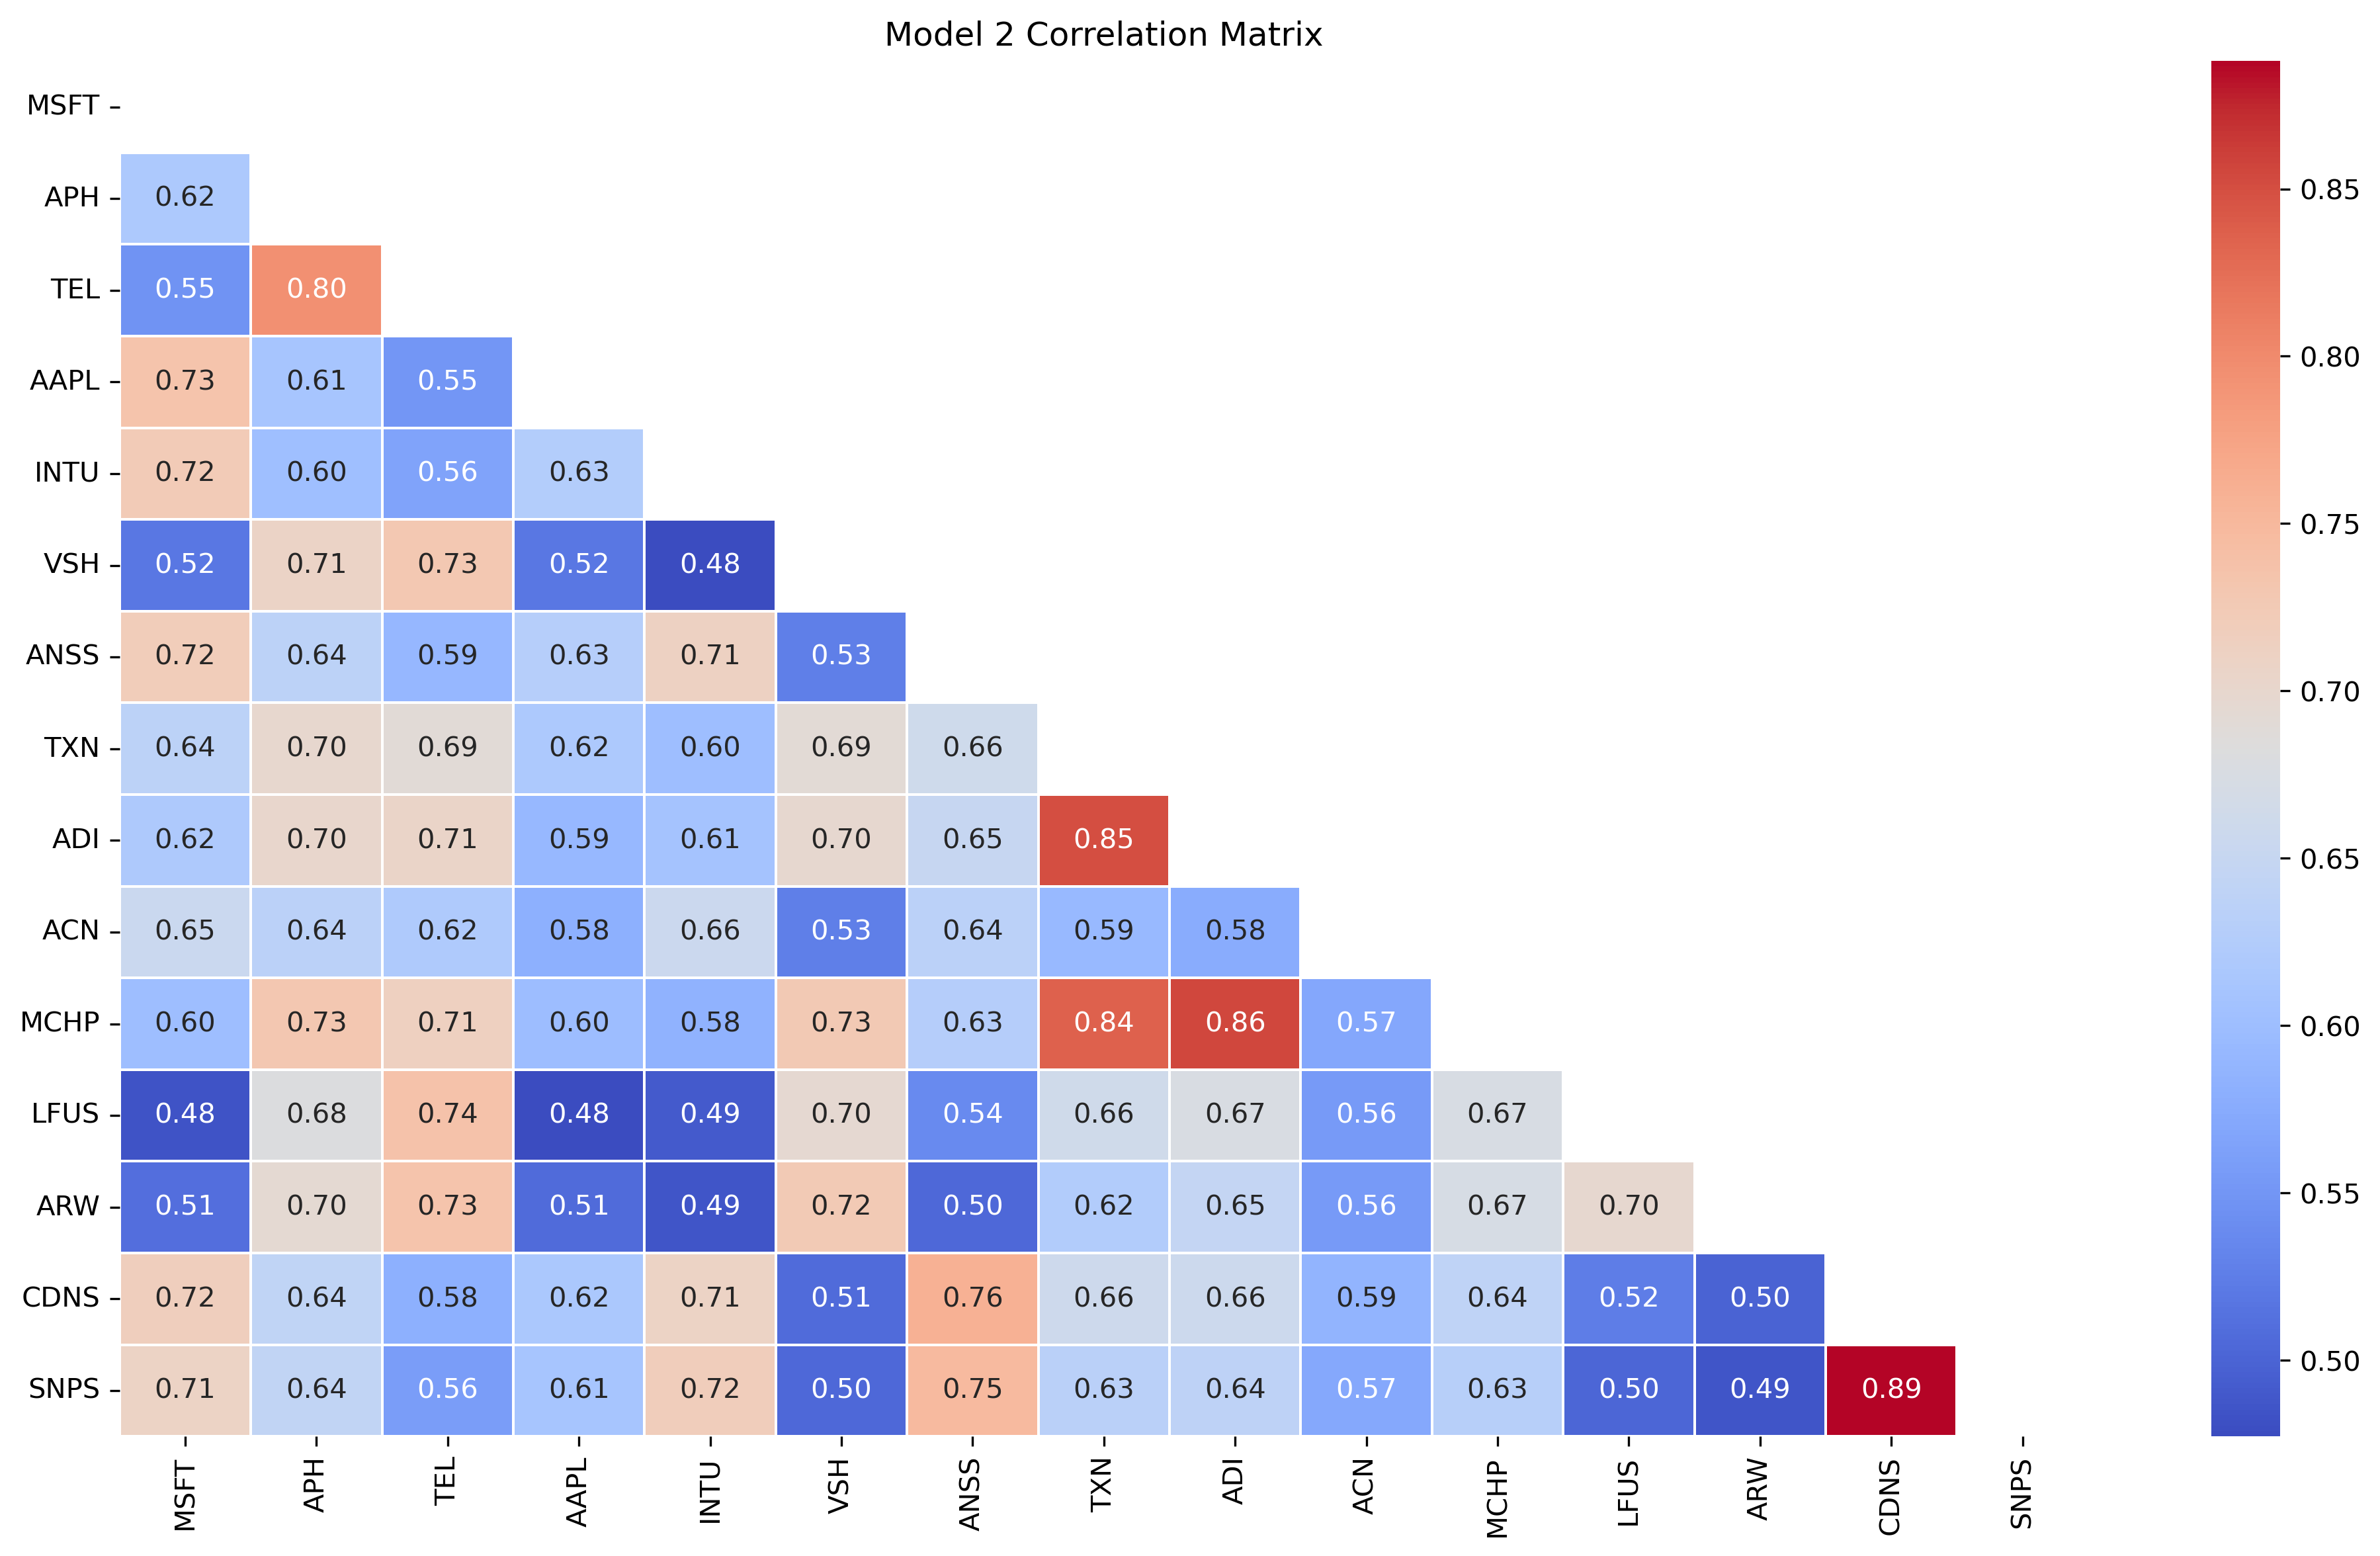

In [32]:
# Correlation Matrices for Each Model
"""
Experimental factor models outperform tradictional ones, but all perform comparatively similarly
Picking the lowest correlated set to continue with
Only visualise least-correlated model
"""

# Correlation matrix dictionary
corr_mx = {}

# Loop through each model & extract tickers
for model in exp_models.columns.levels[0]: # top level index – (Model 1, Model 2, etc.)
    e_tickers = exp_models[model]['Ticker'].dropna().unique() # get unique values (tickers)

    # filter stock_ret df to model tickers
    model_ret = stock_ret[e_tickers]

    # Calculate corr matrix
    corr_mx[model] = model_ret.corr()


# Find Model with Lowest Correlations

# Avg correlation for each model
avg_corr = {model: mx.abs().mean().mean() for model, mx in corr_mx.items()}

# Lowest avg corr
lcorr_model = min(avg_corr, key = avg_corr.get)

print(f'Lowest Avg Correlation: {lcorr_model} ({avg_corr[lcorr_model]:.4f})') # better than printing all results

# Plot matrix for lcorr_model
lcorr_mx = corr_mx[lcorr_model] # extract matrix

mask = np.triu(np.ones_like(lcorr_mx, dtype = bool))

plt.figure(figsize = (16,9), dpi = 300)
sns.heatmap(lcorr_mx, mask = mask, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.5)
plt.title(f'{lcorr_model} Correlation Matrix')
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)

plt.savefig('Lowest Corr Factor Model.png')
plt.show()
    

### 3 – Mean-Variance Optimisation

#### 3.1 – Portfolio Optimisation

In [35]:
# MVO Portfolio Set-Up

# Get final portfolio df – filter stock_ret by best factor model output
fact_tickers = exp_models[lcorr_model]['Ticker'].dropna().unique() # tickers in top factor model
alpha_pf = stock_ret[fact_tickers] # filtered excess returns df ('alpha portfolio')


In [36]:
# Mean-Variance Optimisation – Unconstrained

"""
Unconstrained MVO using Riskfolio library
"""

# Build portfolio object
pfolio = rp.Portfolio(returns = alpha_pf)

# Set method & input parameters
method_mu, method_cov = 'hist', 'hist' # estimate exp. returns & cov.mx based on historical data
pfolio.assets_stats(method_mu = method_mu, method_cov = method_cov)

# Find optimal portfolio
model = 'Classic' # markowitz model (hist. data)
rm = 'MV' # risk measure = variance
obj = 'Sharpe' # objective fuinction = sharpe ratio
rf = mt_rfr # set as medium-term investment
l = 0 # risk aversion factor (not needed for markowitz)
hist = True # use historical scenarios for risk measures

weights_a = pfolio.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(weights_a.T)


MSFT       APH           TEL     AAPL          INTU  \
weights  2.908087e-08  0.057673  2.703186e-09  0.58817  3.323500e-09   

                  VSH          ANSS           TXN           ADI           ACN  \
weights  1.111182e-09  1.693650e-09  2.362871e-09  2.817458e-09  7.837446e-09   

                 MCHP          LFUS           ARW      CDNS          SNPS  
weights  1.182170e-09  1.638942e-09  2.116590e-09  0.354157  4.593747e-08

#### 3.2 – Optimised Portfolio with Constraints

In [38]:
"""
Constraints on stocks' min & max weightings in portfolio (2% & 30%)
Contraints on industry/sectors' max weightings in portfolio (40%)
"""

# Set Linear Constraints – A

pf_assets = alpha_pf.columns.tolist()
pf_info = vgt[vgt['TICKER'].isin(pf_assets)]
pf_info = pf_info[['TICKER', 'SECTOR']].reset_index(drop = True)
pf_info = pf_info.rename(columns = {'TICKER': 'Assets', 'SECTOR': 'Industry'}) # specific col names for Riskfolio library
asset_classes = pf_info.sort_values(by = ['Assets']) # specific df names needed for Riskfolio too

industries = asset_classes['Industry'].unique().tolist()
industries


['Technology Hardware, Storage & Peripherals',
 'IT Services',
 'Semiconductors & Semiconductor Equipment',
 'Software',
 'Electronic Equipment, Instruments & Components']

In [39]:
# Set Linear Constraints – B

constraints = {'Disabled': [False, False, False, False, False, False, False],
               'Type': ['All Assets', 'All Assets', 'Classes', 'Classes',
                        'Classes', 'Classes', 'Classes'],
               
               'Set': ['', '', 'Industry', 'Industry', 'Industry', 'Industry', 'Industry'],
               
               'Position': ['', '', 'Technology Hardware, Storage & Peripherals', 'IT Services',
                            'Semiconductors & Semiconductor Equipment', 'Software',
                            'Electronic Equipment, Instruments & Components'],
               
               'Sign': ['<=', '>=', '<=', '<=', '<=', '<=', '<='],
               'Weight': [0.30, 0.02, 0.4, 0.4, 0.4, 0.4, 0.4],
               'Type Relative': ['', '', '', '', '', '', ''],
               'Relative Set': ['', '', '', '', '', '', ''],
               'Relative': ['', '', '', '', '', '', ''],
               'Factor': ['', '', '', '', '', '', '']}

constraints = pd.DataFrame(constraints)
constraints


Disabled        Type       Set  \
0     False  All Assets             
1     False  All Assets             
2     False     Classes  Industry   
3     False     Classes  Industry   
4     False     Classes  Industry   
5     False     Classes  Industry   
6     False     Classes  Industry   

                                         Position Sign  Weight Type Relative  \
0                                                   <=    0.30                 
1                                                   >=    0.02                 
2      Technology Hardware, Storage & Peripherals   <=    0.40                 
3                                     IT Services   <=    0.40                 
4        Semiconductors & Semiconductor Equipment   <=    0.40                 
5                                        Software   <=    0.40                 
6  Electronic Equipment, Instruments & Components   <=    0.40                 

  Relative Set Relative Factor  
0                               
1                               
2                               
3                               
4                               
5                               
6

In [40]:
A, B = rp.assets_constraints(constraints, asset_classes)

MSFT       APH   TEL  AAPL  INTU   VSH  ANSS   TXN   ADI   ACN  \
weights  0.100993  0.045301  0.02   0.3  0.02  0.02  0.02  0.02  0.02  0.02   

         MCHP  LFUS   ARW  CDNS      SNPS  
weights  0.02  0.02  0.02   0.3  0.053706

/Applications/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Number of Assets: 15
Number of Effective Assets: 5.021691361629783


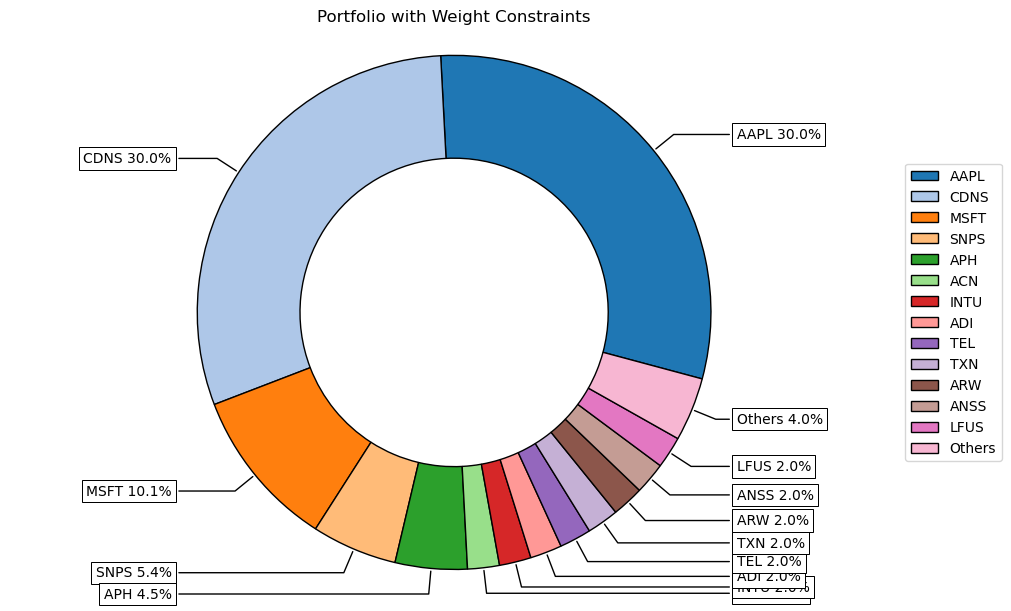

In [41]:
# Optimise Portfolio w/ Constraints
"""
Apply constraints to mean0variance model
Visualise portfolio holdings
"""

pfolio.ainequality = A
pfolio.binequality = B

weights_b = pfolio.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(weights_b.T)



# Number of assets in portfolio
n_assets = np.sum(np.where(np.round(weights_b,4) > 0, 1, 0)).item()

# Plot Portfolio Composition

ax = rp.plot_pie(
    w = weights_b,
    title = 'Portfolio with Weight Constraints',
    others = 0.05,
    nrow = 25,
    cmap = 'tab20',
    height = 6,
    width = 10,
    ax = None)

fig = ax.figure
fig.savefig('Portfolio Pie.png', dpi = 300, bbox_inches = 'tight')

# Number of effective assets in portfolio
nea = 1/np.sum(weights_b ** 2).item()

print('Number of Assets:', n_assets)
print('Number of Effective Assets:', nea)


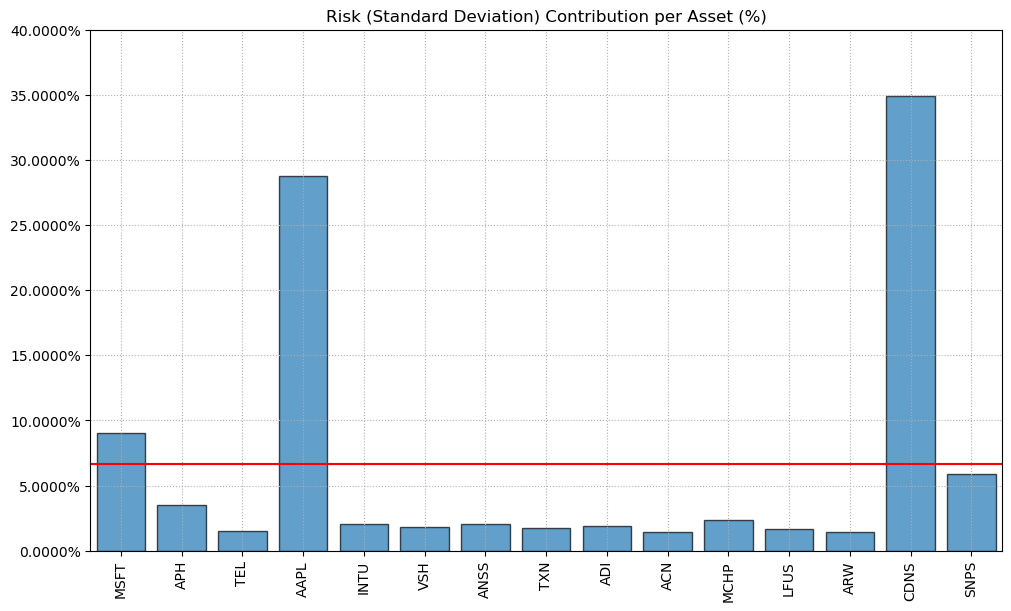

In [42]:
# Plot Asset Risk Contribution
"""
Visualise how much each asset contributed to overall portfolio risk
"""

ax = rp.plot_risk_con(
    weights_b,
    cov = pfolio.cov,
    returns = pfolio.returns,
    rm = rm,
    rf = rf,
    alpha = 0.05,
    color = 'tab:blue',
    percentage = True,
    height = 6,
    width = 10,
    ax = None)

fig = ax.figure
fig.savefig('Portfolio Asset Risk Cont.png', dpi = 300, bbox_inches = 'tight')


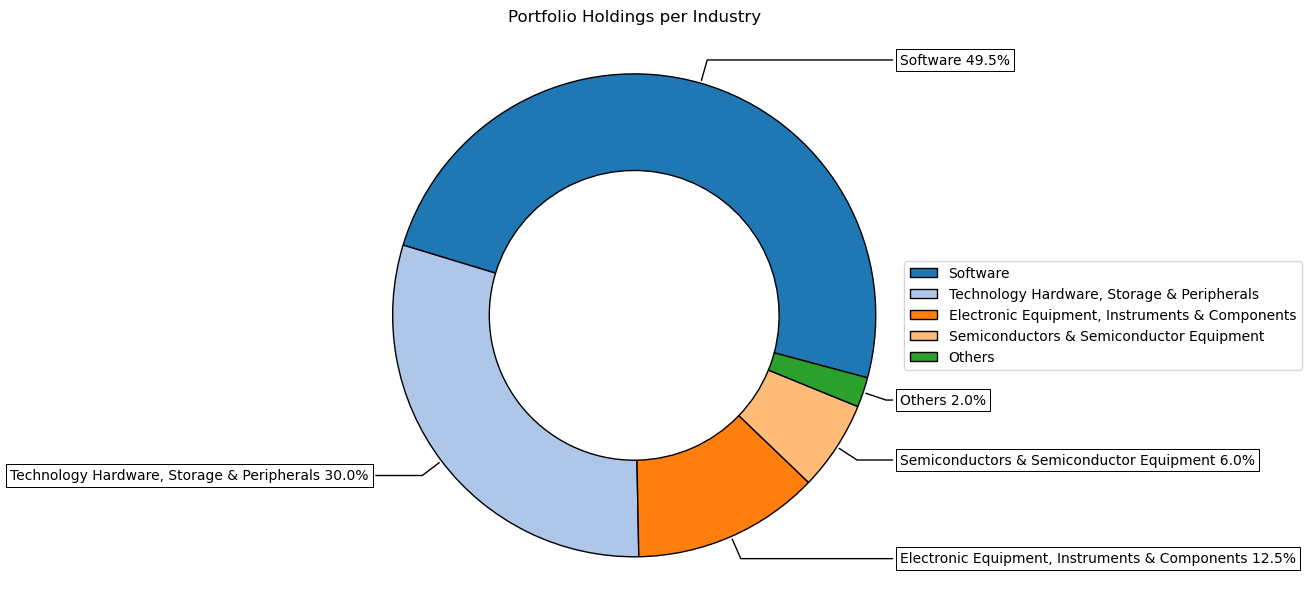

In [43]:
# Portfolio Composisiton per Industry/sector

w_classes_b = pd.concat([asset_classes.set_index('Assets'), weights_b], axis = 1)
w_classes_b = w_classes_b.groupby(['Industry']).sum()

ax = rp.plot_pie(
    w = w_classes_b,
    title = 'Portfolio Holdings per Industry',
    others = 0.05,
    nrow = 25,
    cmap = 'tab20',
    height = 6,
    width = 13,
    ax = None)

fig = ax.figure
fig.savefig('Portfolio Industry Pie.png', dpi = 300, bbox_inches = 'tight')


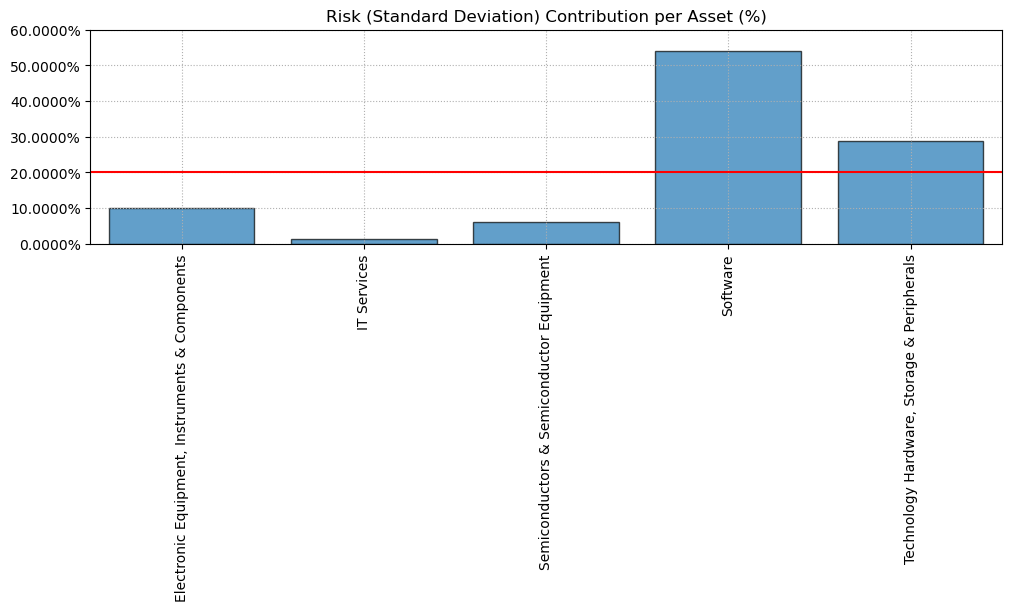

In [44]:
# Plot Industry Risk Contribution

ax = rp.plot_risk_con(
    weights_b,
    cov = pfolio.cov,
    returns = pfolio.returns,
    asset_classes = asset_classes,
    classes_col = 'Industry',
    rm = rm,
    rf = rf,
    alpha = 0.05,
    color = 'tab:blue',
    percentage = True,
    height = 6,
    width = 10,
    ax = None)

fig = ax.figure
fig.savefig('Portfolio Industry Risk Cont.png', dpi = 300, bbox_inches = 'tight')


In [45]:
# Final Portfolio
"""
Total returns for weighted portfolio
Returns of all stocks in portfolio
"""

# PF dataframe w/ total weighted returns columm
final_pf = alpha_pf.copy()
final_pf['Weighted Portfolio'] = final_pf.dot(weights_b.T.values[0])
final_pf = final_pf[['Weighted Portfolio'] + [col for col in final_pf.columns if col != 'Weighted Portfolio']]

final_pf


Weighted Portfolio      MSFT       APH       TEL      AAPL  \
Date                                                                     
2019-01-03           -0.059425 -0.036788 -0.059155 -0.037347 -0.099607   
2019-01-04            0.040669  0.046509  0.032902  0.026232  0.042689   
2019-01-07            0.005226  0.001275  0.007480  0.019776 -0.002226   
2019-01-08            0.011612  0.007251  0.013057 -0.003298  0.019063   
2019-01-09            0.012699  0.014300  0.016932  0.020119  0.016982   
...                        ...       ...       ...       ...       ...   
2024-12-16            0.013577  0.009659  0.023360 -0.000933  0.011728   
2024-12-17           -0.001734  0.006355 -0.012303 -0.013338  0.009720   
2024-12-18           -0.029482 -0.037561 -0.056019 -0.021426 -0.021422   
2024-12-19            0.000684 -0.000823 -0.001284 -0.006147  0.007015   
2024-12-20            0.008077 -0.000984  0.008142 -0.001529  0.018816   

                INTU       VSH      ANSS       TXN       ADI       ACN  \
Date                                                                     
2019-01-03 -0.030596 -0.060384 -0.037550 -0.058973 -0.060405 -0.034142   
2019-01-04  0.039677  0.025826  0.043737  0.045229  0.024278  0.038884   
2019-01-07  0.015255  0.012880  0.025477  0.017223  0.006289  0.003473   
2019-01-08  0.023971  0.008671  0.004955 -0.001270  0.024396  0.025290   
2019-01-09 -0.003099  0.020630  0.017494  0.019708  0.025340  0.005030   
...              ...       ...       ...       ...       ...       ...   
2024-12-16  0.022926 -0.003930  0.006966 -0.011117 -0.001385 -0.004517   
2024-12-17  0.009337 -0.012965  0.001343 -0.007073 -0.011511  0.000672   
2024-12-18 -0.041253 -0.007424 -0.027312 -0.016585 -0.028295 -0.027120   
2024-12-19 -0.019790 -0.021289  0.002337 -0.002865  0.000048  0.070625   
2024-12-20  0.010111  0.009994  0.011660  0.013010  0.019251 -0.015558   

                MCHP      LFUS       ARW      CDNS      SNPS  
Date                                                          
2019-01-03 -0.070497 -0.041138 -0.042559 -0.039325 -0.034979  
2019-01-04  0.040561  0.043638  0.038444  0.041657  0.034398  
2019-01-07  0.029271  0.010571  0.016052  0.003699  0.022169  
2019-01-08  0.027172  0.024291 -0.002704  0.005758  0.003965  
2019-01-09  0.039611  0.024055  0.012131  0.004122  0.009988  
...              ...       ...       ...       ...       ...  
2024-12-16 -0.014183  0.013155 -0.008396  0.021972  0.027209  
2024-12-17 -0.013372 -0.023243 -0.011485 -0.006826 -0.019613  
2024-12-18 -0.036885 -0.033396 -0.017978 -0.032472 -0.034071  
2024-12-19 -0.002672 -0.006834 -0.003282 -0.004548 -0.002184  
2024-12-20 -0.008573  0.001923 -0.005805  0.005336 -0.002372  

[1503 rows x 16 columns]

#### 3.3 – Benchmark Portfolio with Constraints

In [47]:
# Apply Portfolio Weighting Constraints to Benchmark

"""
Constraints on stocks' min & max weightings in portfolio (2% & 30%)
Contraints on industry/sectors' max weightings in portfolio (40%)
"""

# Set Linear Constraints – A

bm_assets = stock_ret.columns.tolist() # repeat line; keeping for clarity
bm_info = vgt[vgt['TICKER'].isin(bm_assets)]
bm_info = bm_info[['TICKER', 'SECTOR']].reset_index(drop = True)
bm_info = bm_info.rename(columns = {'TICKER': 'Assets', 'SECTOR': 'Industry'}) # specific col names for Riskfolio library
asset_classes = bm_info.sort_values(by = ['Assets']) # specific df names needed for Riskfolio too

industries = asset_classes['Industry'].unique().tolist()
industries


['Technology Hardware, Storage & Peripherals',
 'Software',
 'Semiconductors & Semiconductor Equipment',
 'IT Services',
 'Communications Equipment',
 'Electronic Equipment, Instruments & Components']

In [48]:
# Set Linear Constraints – B

constraints = {'Disabled': [False, False, False, False, False, False, False, False],
               'Type': ['All Assets', 'All Assets', 'Classes', 'Classes',
                        'Classes', 'Classes', 'Classes', 'Classes'],
               
               'Set': ['', '', 'Industry', 'Industry', 'Industry', 'Industry', 'Industry', 'Industry'],
               
               'Position': ['', '', 'Technology Hardware, Storage & Peripherals',
                            'Software', 'Semiconductors & Semiconductor Equipment',
                            'IT Services', 'Communications Equipment',
                            'Electronic Equipment, Instruments & Components'],
               
               'Sign': ['<=', '>=', '<=', '<=', '<=', '<=', '<=', '<='],
               'Weight': [0.30, 0.0, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], # min stock % = 0 – too many assets in bm
               'Type Relative': ['', '', '', '', '', '', '', ''],
               'Relative Set': ['', '', '', '', '', '', '', ''],
               'Relative': ['', '', '', '', '', '', '', ''],
               'Factor': ['', '', '', '', '', '', '', '']}

constraints = pd.DataFrame(constraints)
constraints


Disabled        Type       Set  \
0     False  All Assets             
1     False  All Assets             
2     False     Classes  Industry   
3     False     Classes  Industry   
4     False     Classes  Industry   
5     False     Classes  Industry   
6     False     Classes  Industry   
7     False     Classes  Industry   

                                         Position Sign  Weight Type Relative  \
0                                                   <=     0.3                 
1                                                   >=     0.0                 
2      Technology Hardware, Storage & Peripherals   <=     0.4                 
3                                        Software   <=     0.4                 
4        Semiconductors & Semiconductor Equipment   <=     0.4                 
5                                     IT Services   <=     0.4                 
6                        Communications Equipment   <=     0.4                 
7  Electronic Equipment, Instruments & Components   <=     0.4                 

  Relative Set Relative Factor  
0                               
1                               
2                               
3                               
4                               
5                               
6                               
7

In [49]:
A, B = rp.assets_constraints(constraints, asset_classes)

PMTS           VPG          FFIV           DBX           VYX  \
weights  0.128345  2.150932e-11  3.465971e-11  3.383770e-11  1.880101e-11   

                  VSH          WDAY      NVDA          INTC          EGHT  \
weights  1.892027e-11  2.729536e-11  0.173405  1.548302e-11  1.142167e-11   

         ...          SEDG          AMKR          IPGP          CDNS  \
weights  ...  1.402918e-11  2.653131e-11  1.787731e-11  8.216337e-11   

                 LWLG           TXN          SLAB          AMBA          GDDY  \
weights  4.367527e-10  3.259883e-11  1.791018e-11  2.003622e-11  5.366324e-11   

                 CNXN  
weights  1.040034e-10  

[1 rows x 229 columns]

Number of Assets: 16
Number of Effective Assets: 9.482355531812855


/Applications/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


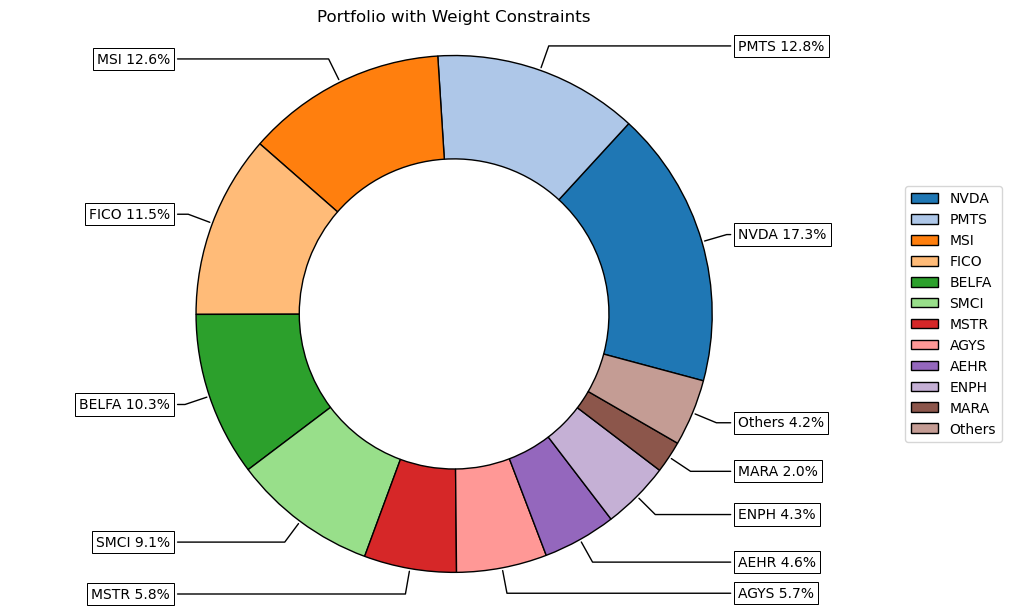

In [50]:
# Optimise Portfolio w/ Constraints
"""
Apply constraints to mean-variance model
Visualise benchmark holdings
"""

# Build portfolio object
bmark = rp.Portfolio(returns = stock_ret)

# Set method & input parameters
method_mu, method_cov = 'hist', 'hist' # estimate exp. returns & cov.mx based on historical data
bmark.assets_stats(method_mu = method_mu, method_cov = method_cov)

# Set up model
model = 'Classic' # markowitz model (hist. data)
rm = 'MV' # risk measure = variance
obj = 'Sharpe' # objective fuinction = sharpe ratio
rf = mt_rfr # medium-term investment
l = 0 # risk aversion factor (not needed for markowitz)
hist = True # use historical scenarios for risk measures

weights_bm = bmark.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist) # unconstrained run (don't display)

# Apply Linear Constraints
bmark.ainequality = A
bmark.binequality = B

weights_bm2 = bmark.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(weights_bm2.T)



# Number of assets in portfolio
n_assets = np.sum(np.where(np.round(weights_bm2 ,4) > 0, 1, 0)).item()

# Plot Portfolio Composition

ax = rp.plot_pie(
    w = weights_bm2,
    title = 'Portfolio with Weight Constraints',
    others = 0.05,
    nrow = 25,
    cmap = 'tab20',
    height = 6,
    width = 10,
    ax = None)

# Number of effective assets in portfolio
nea = 1/np.sum(weights_bm2 ** 2).item()

print('Number of Assets:', n_assets)
print('Number of Effective Assets:', nea)


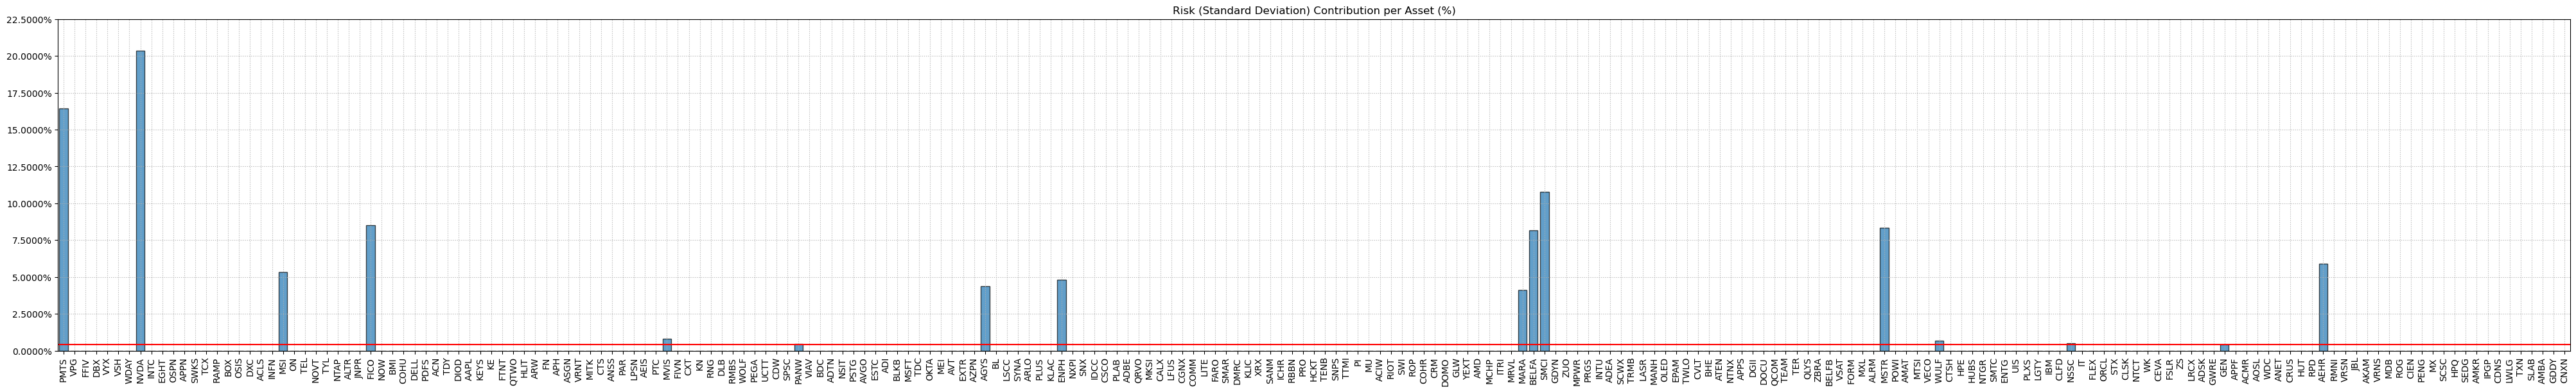

In [51]:
# Plot Benchmark Asset Risk Contribution
"""
Visualise how much each asset contributed to overall portfolio risk
"""

ax = rp.plot_risk_con(
    weights_bm2,
    cov = bmark.cov,
    returns = bmark.returns,
    rm = rm,
    rf = rf,
    alpha = 0.05,
    color = 'tab:blue',
    percentage = True,
    height = 6,
    width = 40,
    ax = None)

# double-click to zoom


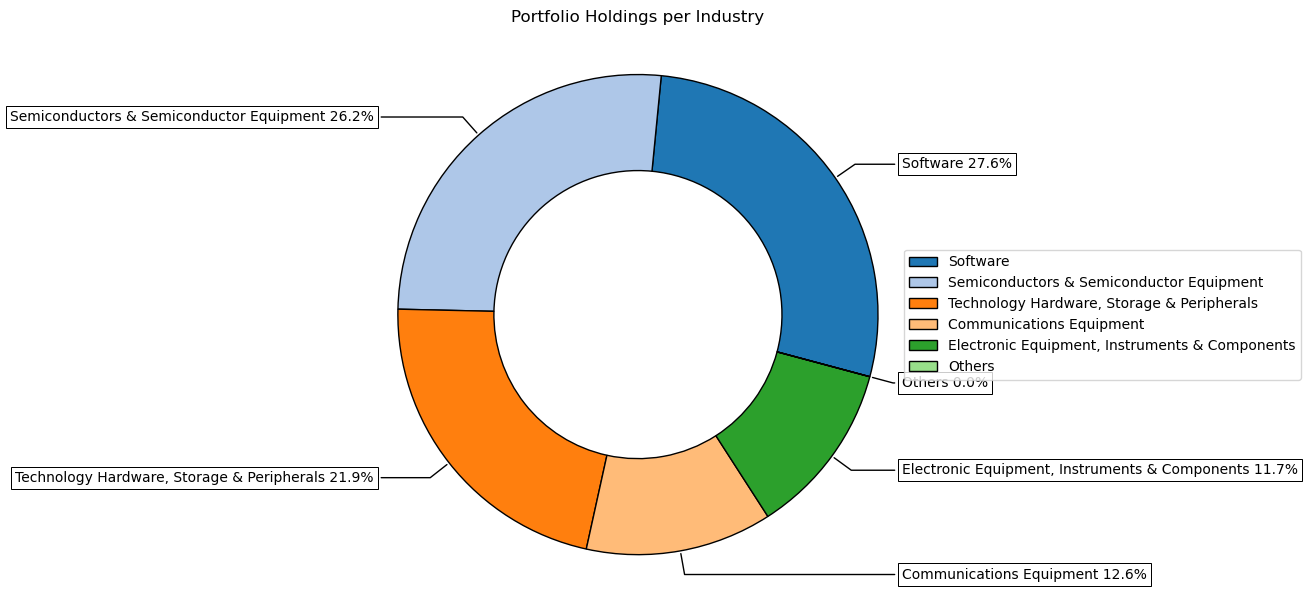

In [52]:
# Benchmark Composisiton per Industry/sector

w_classes_bm = pd.concat([asset_classes.set_index('Assets'), weights_bm2], axis = 1)
w_classes_bm = w_classes_bm.groupby(['Industry']).sum()

ax = rp.plot_pie(
    w = w_classes_bm,
    title = 'Portfolio Holdings per Industry',
    others = 0.05,
    nrow = 25,
    cmap = 'tab20',
    height = 6,
    width = 13,
    ax = None)


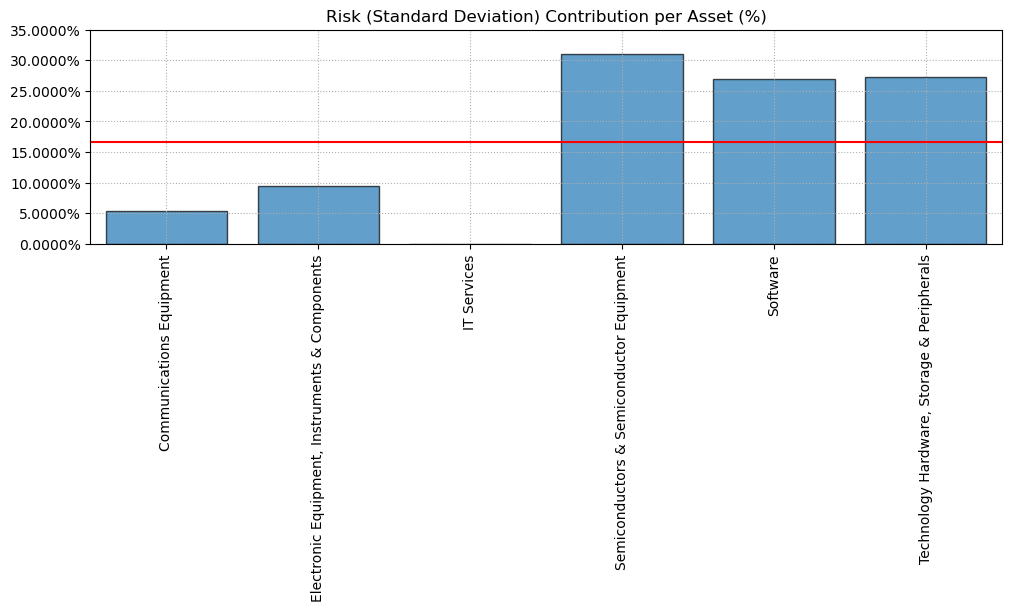

In [53]:
# Plot Benchmark Industry Risk Contribution

ax = rp.plot_risk_con(
    weights_bm2,
    cov = bmark.cov,
    returns = bmark.returns,
    asset_classes = asset_classes,
    classes_col = 'Industry',
    rm = rm,
    rf = rf,
    alpha = 0.05,
    color = 'tab:blue',
    percentage = True,
    height = 6,
    width = 10,
    ax = None)


In [54]:
# Constrained Benchmark Dataframe

cs_bmark = stock_ret.copy() # 'constrained benchmark'
cs_bmark['Weighted Portfolio'] = cs_bmark.dot(weights_bm2.T.values[0])
cs_bmark = cs_bmark[['Weighted Portfolio'] + [col for col in cs_bmark.columns if col != 'Weighted Portfolio']]


### 4 – Portfolio Performance Analysis

#### 4.1 – Portfolio Holdings Metrics

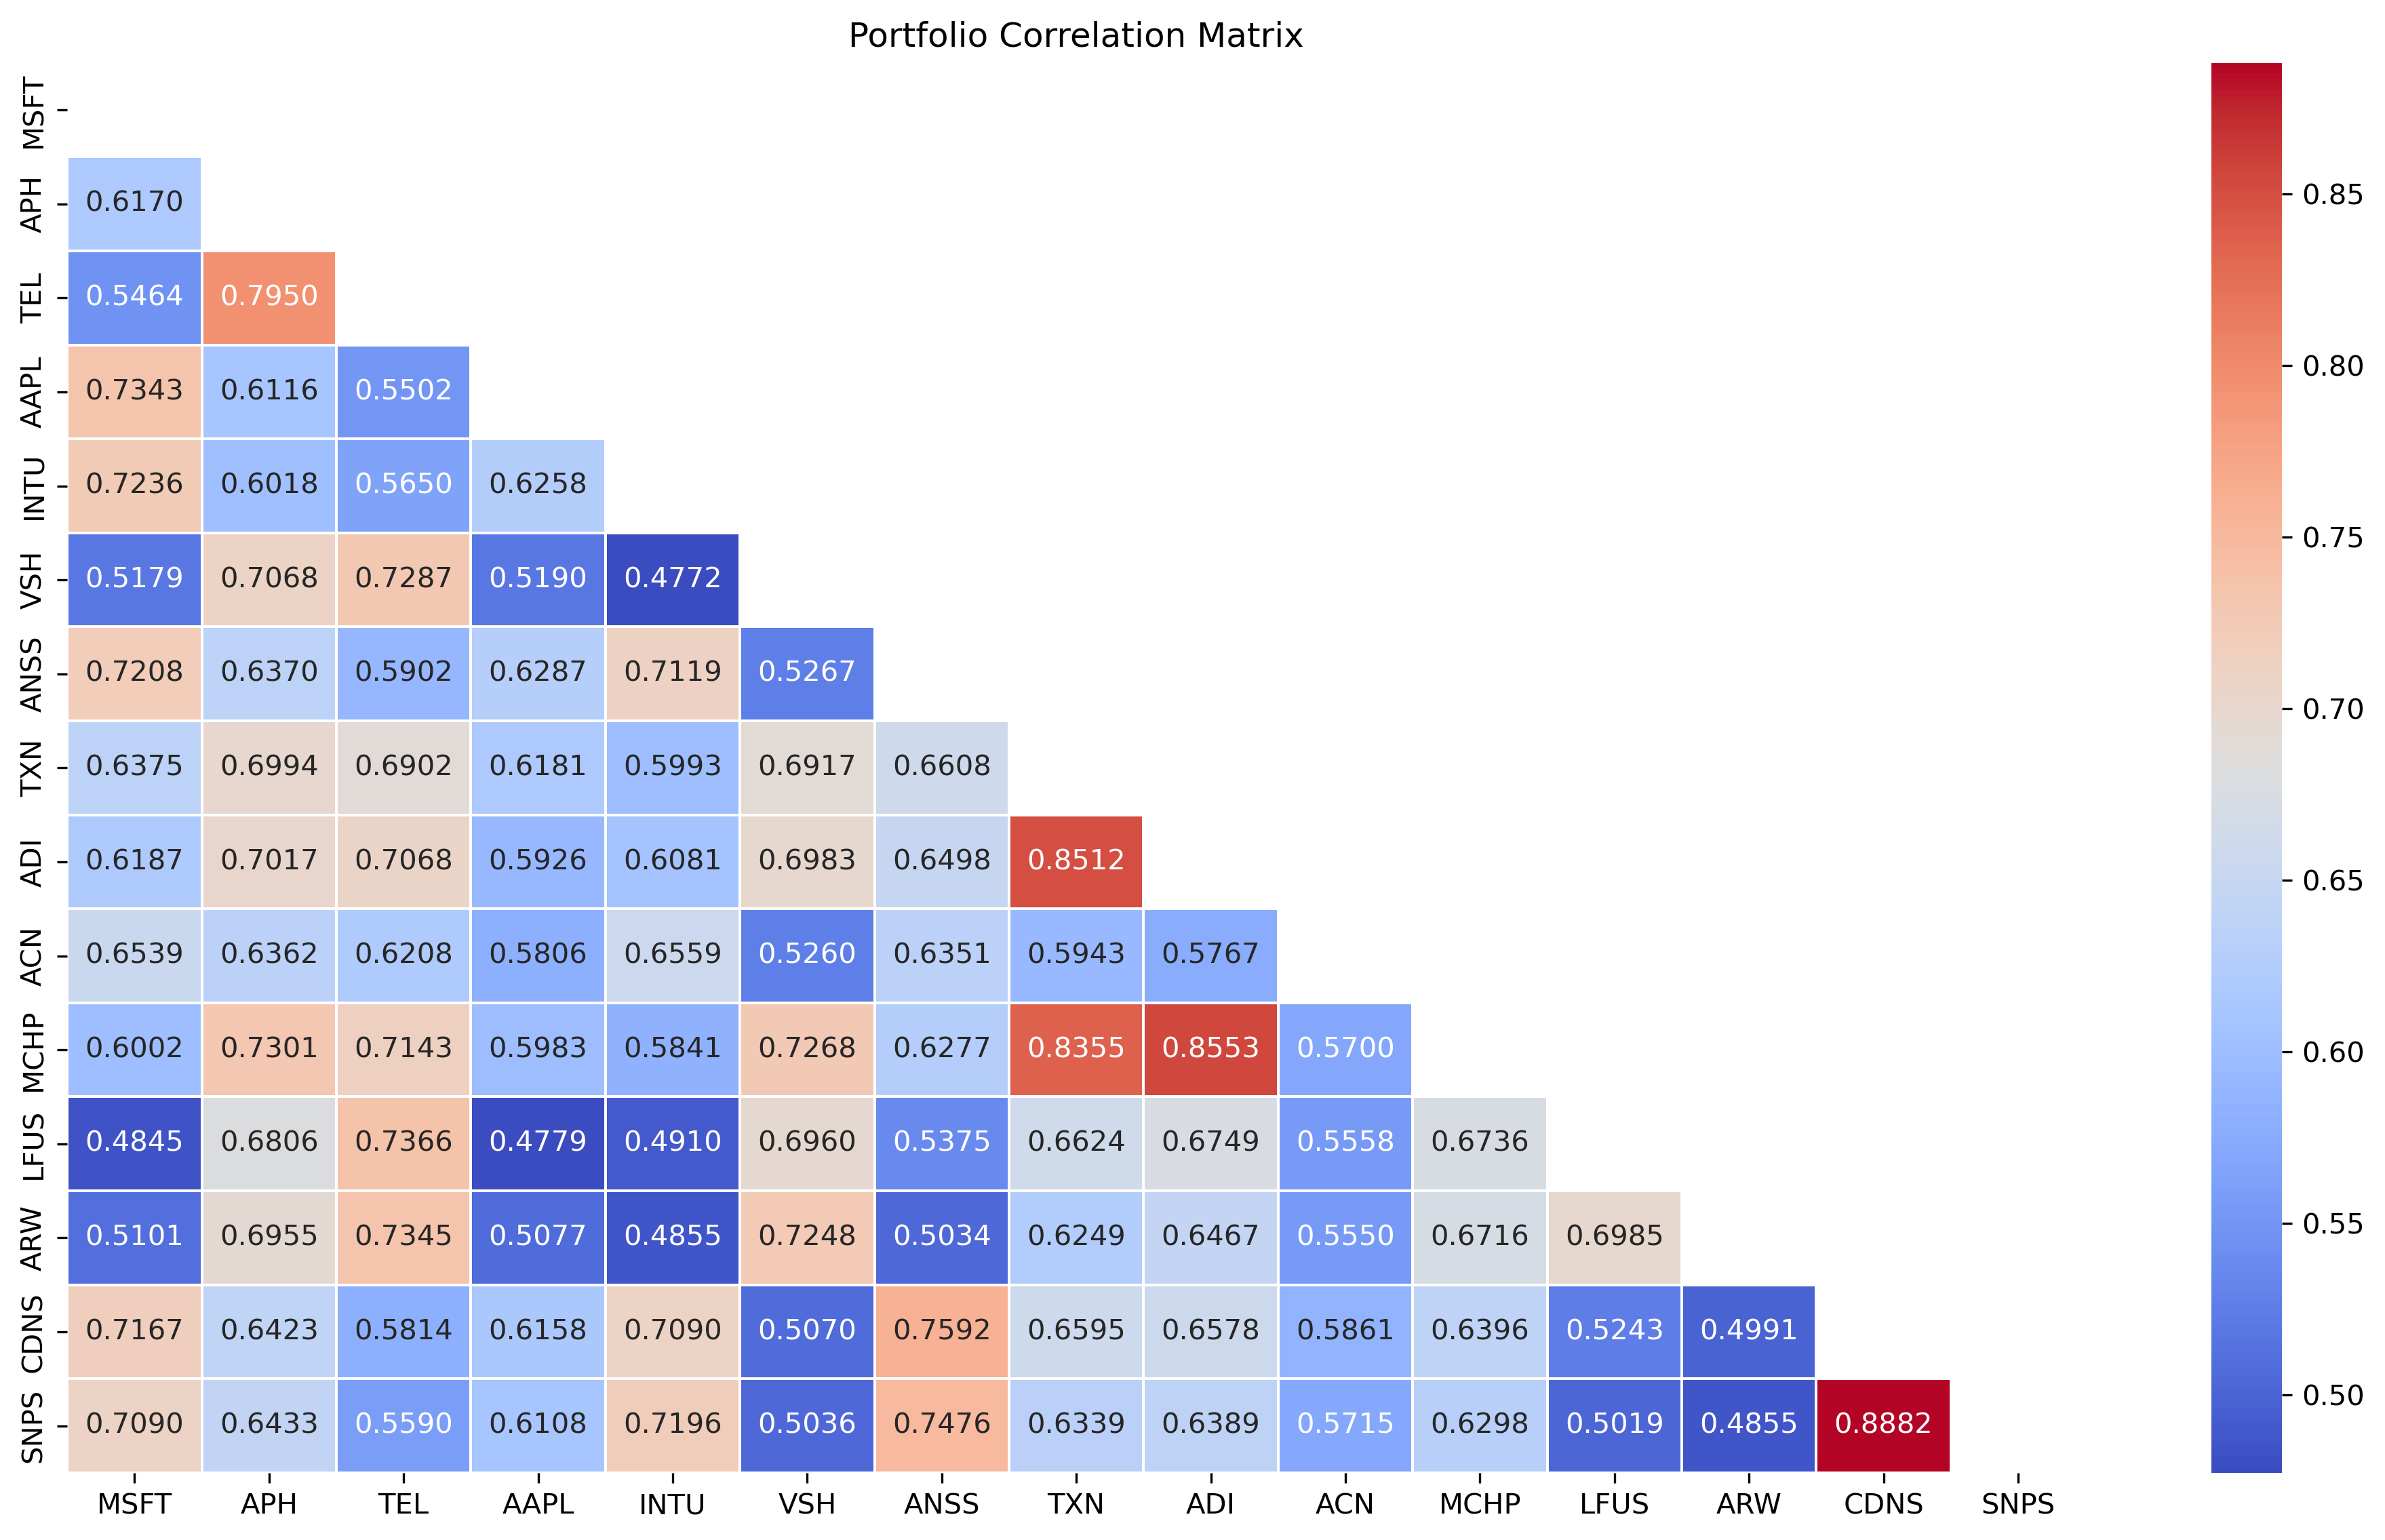

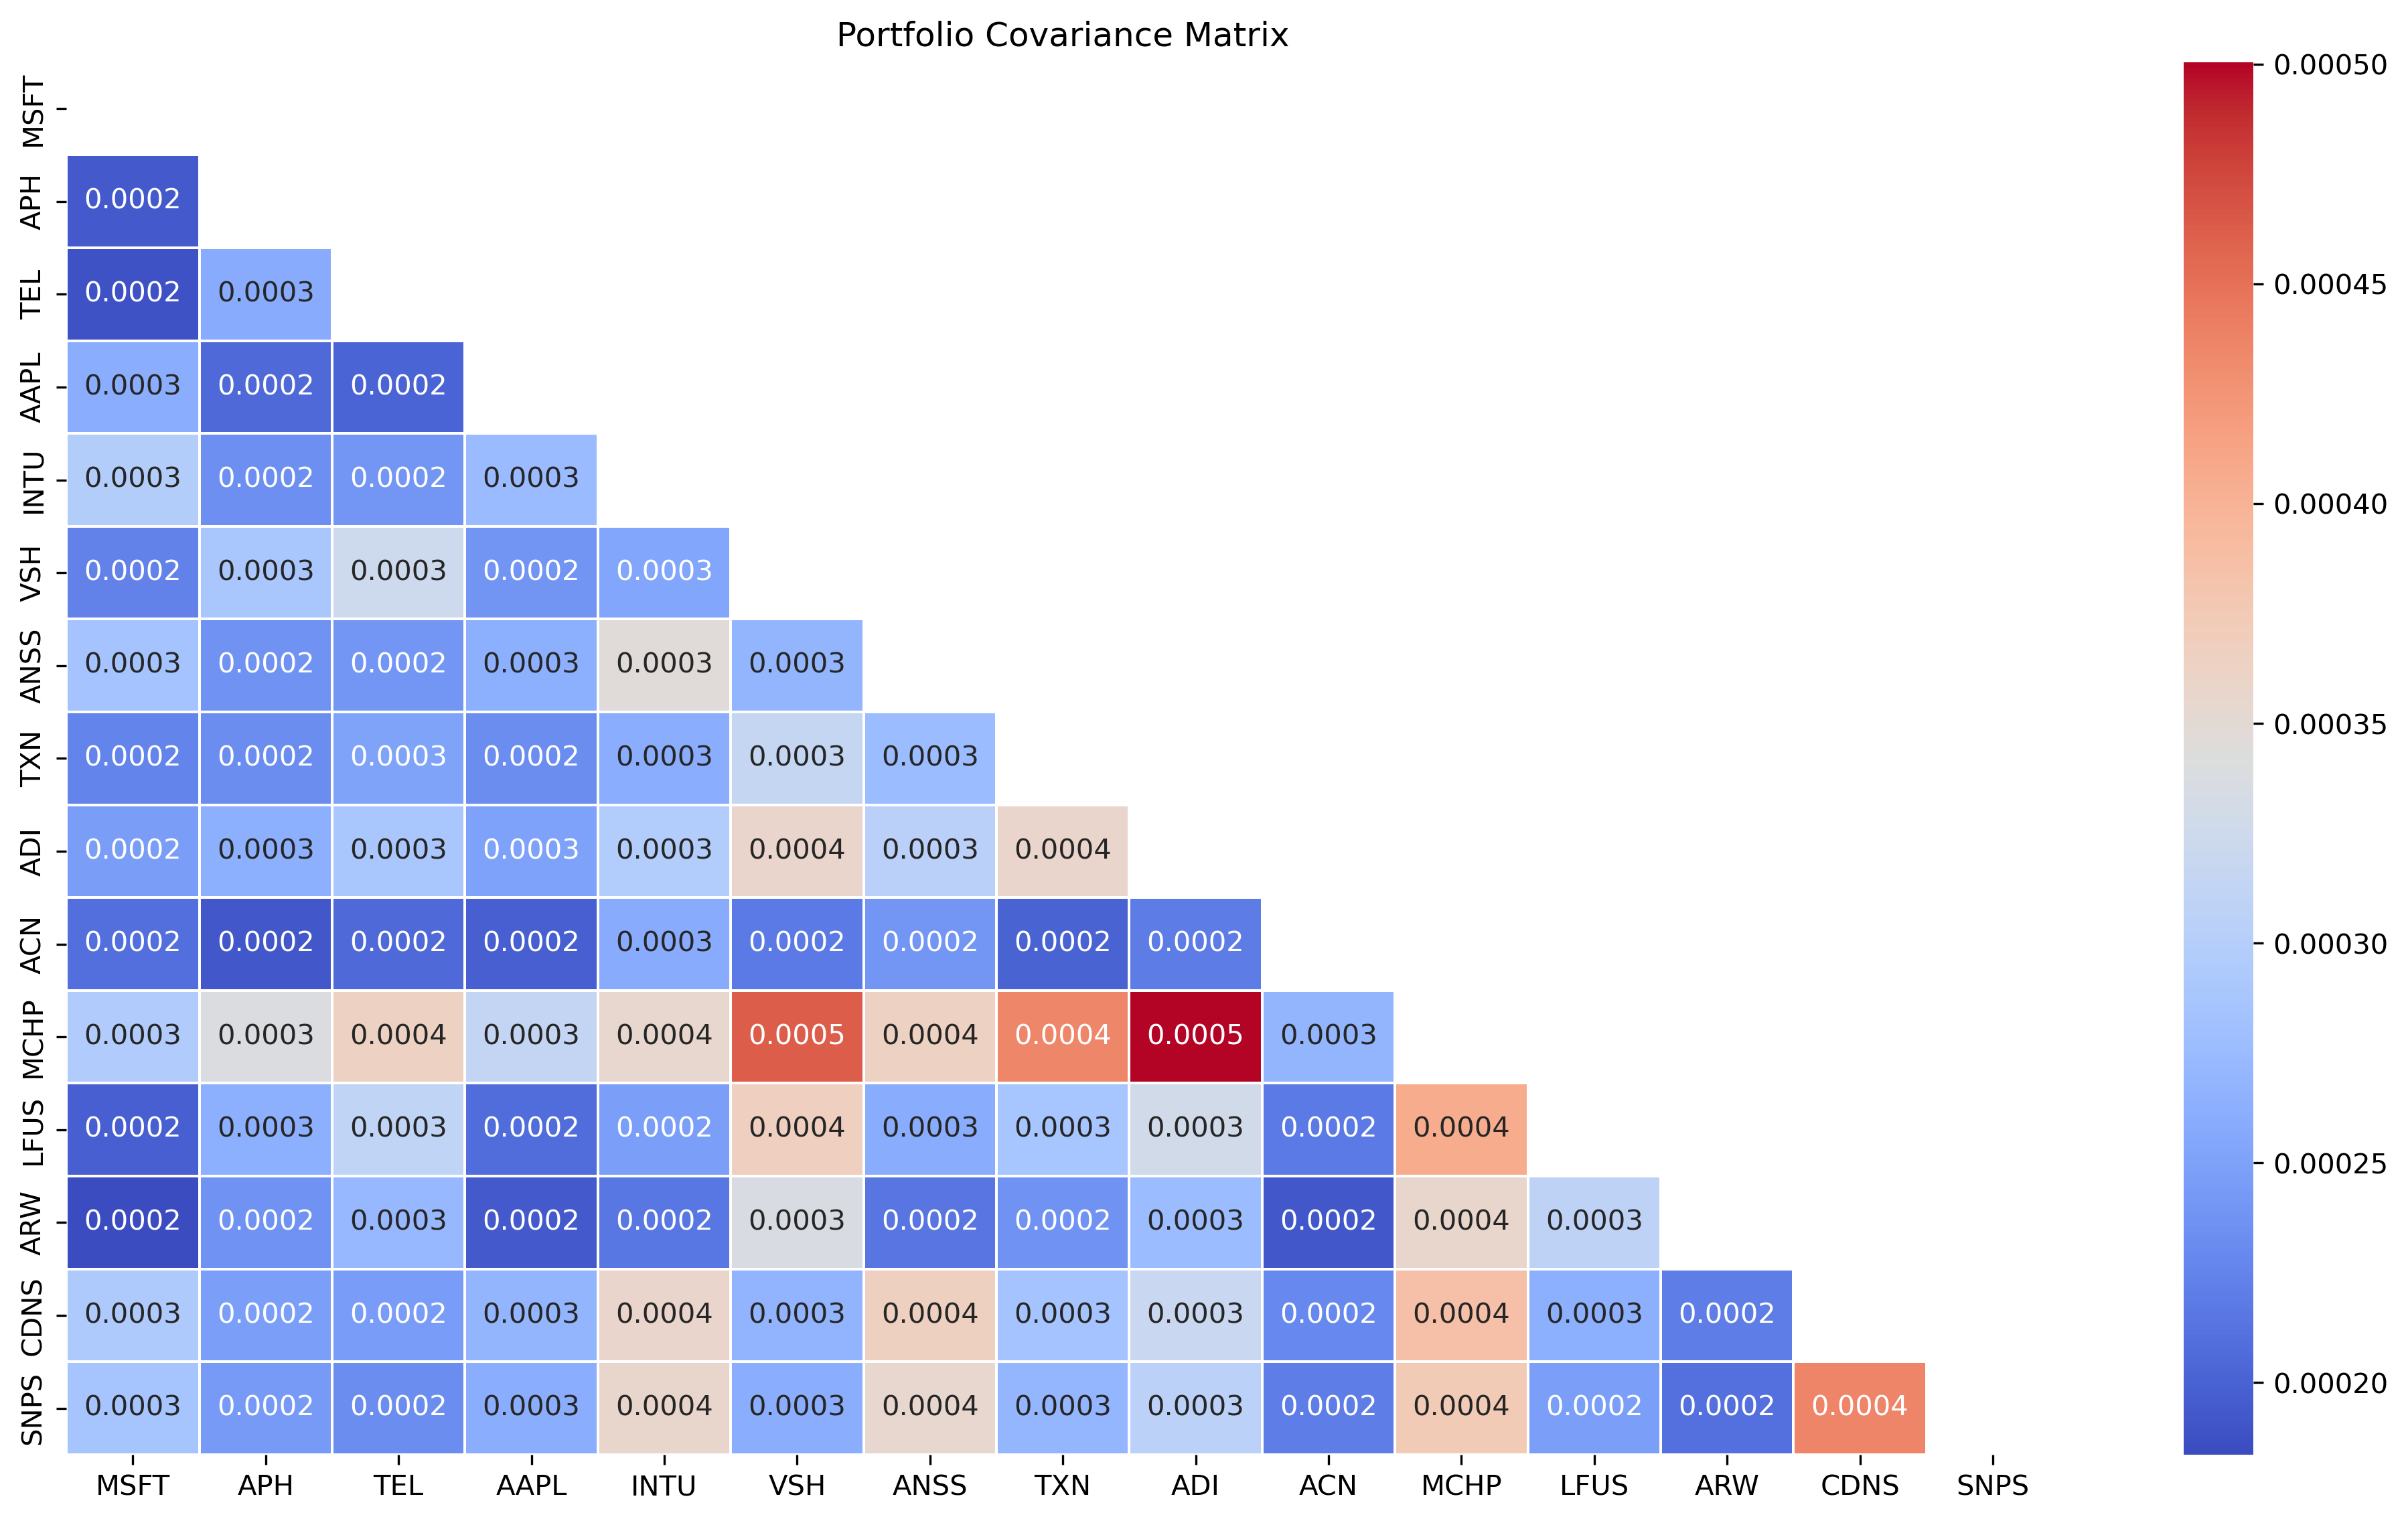

In [57]:
# Correlation & Covariance Matrices
"""
Corr & cov matrices for final portfolio
"""

# Correlation and covariance matrices
corr_mx = alpha_pf.corr()
cov_mx = alpha_pf.cov()

# Mask upper triangles
mask_corr = np.triu(np.ones_like(corr_mx, dtype = bool))
mask_cov = np.triu(np.ones_like(cov_mx, dtype = bool))

# Plot corr matrix
plt.figure(figsize=(16, 9), dpi = 300) # Set up figure (subplots not playing nice with masks)
sns.heatmap(corr_mx, mask = mask_corr, annot = True, fmt = '.4f', cmap = 'coolwarm', linewidths = 0.5)
plt.title('Portfolio Correlation Matrix')
plt.savefig('Portfolio Correlation Matrix.png')
plt.show()

# Plot cov matrix
plt.figure(figsize=(16, 9), dpi = 300)
sns.heatmap(cov_mx, mask = mask_cov, annot = True, fmt = '.4f', cmap = 'coolwarm', linewidths = 0.5)
plt.title('Portfolio Covariance Matrix')
plt.savefig('Portfolio Covariance Matrix.png')
plt.show()


#### 4.2 – Comparative Analysis Set-Up

##### 4.2.1 – Benchmark Index Weighted Portfolio Returns

In [60]:
# Comparative Analysis of Portfolio & Benchmarks

# Get Weighted Benchmark Excess Returns
"""
(Can't just use ETF returns, as some stock data is missing from yfinance
& non-US stocks were dropped This is more accurate)
"""
common_tickers = bm_assets # list of downlaoded stocks
vgt_filtered = vgt[vgt['TICKER'].isin(common_tickers)].copy() # Filter out missing stocks

# Convert vgt '% OF FUNDS*' col to numeric
vgt_filtered['% OF FUNDS*'] = pd.to_numeric(vgt_filtered['% OF FUNDS*'], errors='coerce') # set '<0.01%' to NaN
missing_weight = 1 - vgt_filtered['% OF FUNDS*'].sum() # calculate missing weight (sum of <0.01% stocks)
num_missing = vgt_filtered['% OF FUNDS*'].isna().sum() # count number of tickers with missing weights

# Evenly dist. missing weight amongst '<0.01%' tickers
if num_missing > 0:
    vgt_filtered.loc[vgt_filtered['% OF FUNDS*'].isna(), '% OF FUNDS*'] = missing_weight / num_missing

# Normalise weights so they sum to 1
bm_weights = vgt_filtered.set_index('TICKER')['% OF FUNDS*']
bm_weights /= bm_weights.sum()

# Benchmark index weighted portfolio
bm_index = stock_ret[common_tickers].dot(bm_weights.loc[common_tickers])


##### 4.2.2 – Constrained Benchmark Weighted Portfolio Resturns

In [62]:
cs_bmark = stock_ret.copy() # 'constrained benchmark'
cs_bmark['Weighted Portfolio'] = cs_bmark.dot(weights_bm2.T.values[0])
cs_bmark = cs_bmark[['Weighted Portfolio'] + [col for col in cs_bmark.columns if col != 'Weighted Portfolio']]


##### 4.2.3 – Prepare Data & Define Analysis Functions

In [64]:
# Create df
pf_stats = pd.DataFrame({
    'Portfolio': final_pf['Weighted Portfolio'],
    'Benchmark': bm_index,
    'Const. Benchmark': cs_bmark ['Weighted Portfolio']
})

pf_stats


Portfolio  Benchmark  Const. Benchmark
Date                                              
2019-01-03  -0.059425  -0.053946         -0.015426
2019-01-04   0.040669   0.045396          0.026877
2019-01-07   0.005226   0.020278          0.035787
2019-01-08   0.011612   0.004156         -0.000882
2019-01-09   0.012699   0.015965          0.004378
...               ...        ...               ...
2024-12-16   0.013577   0.012100          0.004924
2024-12-17  -0.001734  -0.005076         -0.003489
2024-12-18  -0.029482  -0.030749         -0.045069
2024-12-19   0.000684   0.000239         -0.010627
2024-12-20   0.008077   0.014603          0.033761

[1503 rows x 3 columns]

In [65]:
# Comparative Analysis Metrics

# Arithmetic Returns Function
def arithMets(df, rf_rate):
    
    # Expected Annualised Returns
    pf_exp_ret = df.mean() * 252  # 252 trading days per year
    
    # Sharpe Ratio (adjusted for risk-free rate)
    vol = df.std()  # volatility
    sharpe = (df.mean() - rf_rate) / vol
    
    # Sortino Ratio (adjusted for risk-free rate)
    ds_vol = df[df < rf_rate].std()  # downside volatility
    sortino = (df.mean() - rf_rate) / ds_vol
    
    # Maximum Drawdown
    c_ret = (1 + df).cumprod()  # cumulative returns
    r_max = c_ret.cummax()  # rolling max
    dd = (c_ret - r_max) / r_max  # drawdown
    max_dd = dd.min()  # maximum drawdown
    
    # Calmar Ratio
    calmar = (df.mean() - rf_rate) / abs(max_dd)
    
    # Information Ratio (adjusted for risk-free rate)
    t_error = (df['Portfolio'] - df['Benchmark']).std()  # tracking error
    info = ((df['Portfolio'] - df['Benchmark']).mean() - rf_rate) / t_error
    
    # DF of metrics
    ret_metrics = pd.DataFrame({
        'Expected Returns': pf_exp_ret,
        'Volatility': vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_dd,
        'Calmar Ratio': calmar,
        'Information Ratio': info
    })
    
    return ret_metrics


#### 4.3 – Portfolio Returns Analysis

##### 4.3.1 – Arithmetic Returns Metrics

In [68]:
# Run Metrics
"""
Show basic suite of analytical mertrics for weighted portfolio & benchmark
Benchmark's expected returns are higher, as is its sharpe ratio

Likely due to the constraints set on stock & industry weightings
& the need for explainability through factor models
"""

st_mets = arithMets(pf_stats, st_rfr) # short-term
print('Short-Term Investment')
display(st_mets)

mt_mets = arithMets(pf_stats, mt_rfr) # med-term
print('\nMedium-Term Investment')
display(mt_mets)

lt_mets = arithMets(pf_stats, lt_rfr) # long-term
print('\nLong-Term Investment')
display(lt_mets)


Short-Term Investment


Expected Returns  Volatility  Sharpe Ratio  Sortino Ratio  \
Portfolio                 0.324113    0.017428      0.068468       0.093572   
Benchmark                 0.375074    0.018366      0.075983       0.102119   
Const. Benchmark          0.645286    0.020640      0.119564       0.174118   

                  Max Drawdown  Calmar Ratio  Information Ratio  
Portfolio            -0.313078      0.003811          -0.051374  
Benchmark            -0.390498      0.003574          -0.051374  
Const. Benchmark     -0.409109      0.006032          -0.051374


Medium-Term Investment


Expected Returns  Volatility  Sharpe Ratio  Sortino Ratio  \
Portfolio                 0.324113    0.017428      0.068395       0.093472   
Benchmark                 0.375074    0.018366      0.075914       0.102025   
Const. Benchmark          0.645286    0.020640      0.119502       0.174028   

                  Max Drawdown  Calmar Ratio  Information Ratio  
Portfolio            -0.313078      0.003807          -0.051596  
Benchmark            -0.390498      0.003570          -0.051596  
Const. Benchmark     -0.409109      0.006029          -0.051596


Long-Term Investment


Expected Returns  Volatility  Sharpe Ratio  Sortino Ratio  \
Portfolio                 0.324113    0.017428      0.068000       0.092932   
Benchmark                 0.375074    0.018366      0.075539       0.101521   
Const. Benchmark          0.645286    0.020640      0.119168       0.173542   

                  Max Drawdown  Calmar Ratio  Information Ratio  
Portfolio            -0.313078      0.003785          -0.052795  
Benchmark            -0.390498      0.003553          -0.052795  
Const. Benchmark     -0.409109      0.006012          -0.052795

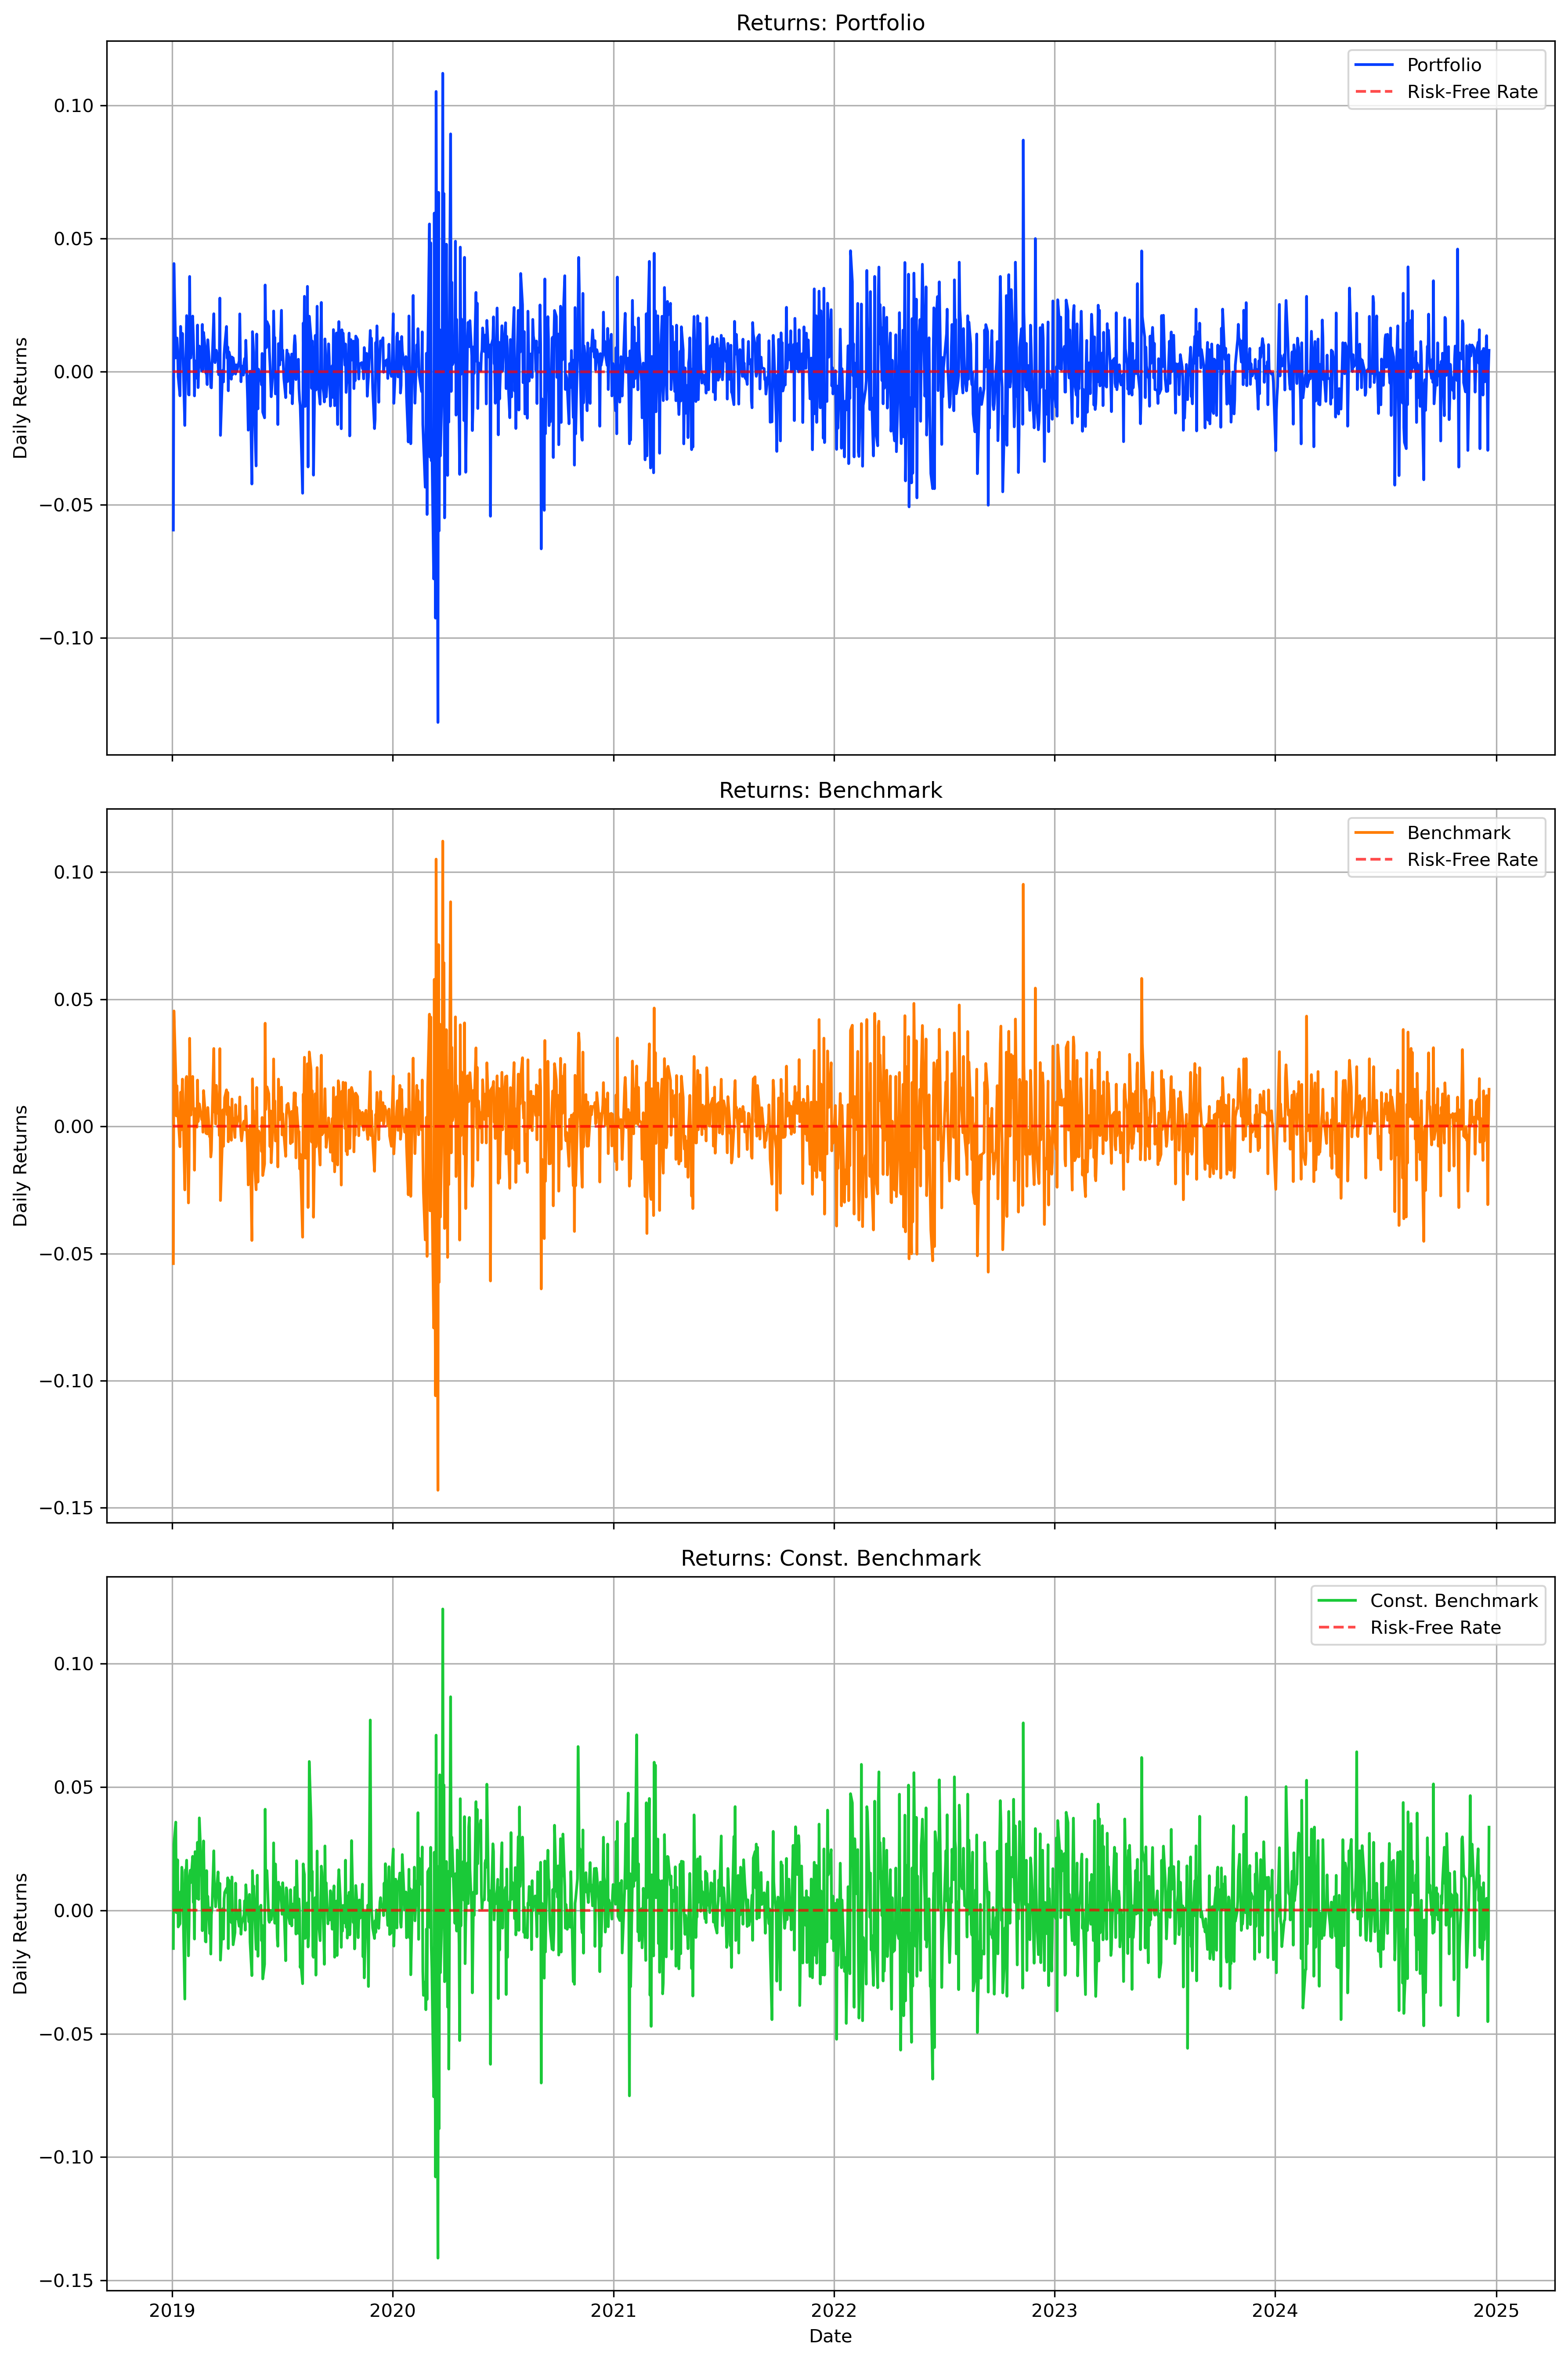

In [69]:

# Define color palettes
pf_palette = sns.color_palette('bright', len(pf_stats.columns))
#rfr_color = sns.color_palette("muted", 1)[0]  # Single muted color for risk-free rate

# Create subplots
fig, axes = plt.subplots(nrows=len(pf_stats.columns), ncols = 1, figsize = (12, 6 * len(pf_stats.columns)), dpi = 300, sharex = True)

# If there's only one column, axes is iterable
if len(pf_stats.columns) == 1:
    axes = [axes]

# Plot each portfolio in subplot
for i, col in enumerate(pf_stats.columns):
    ax = axes[i]
    
    # Portfolio returns
    ax.plot(pf_stats.index, pf_stats[col], label = col, color = pf_palette[i])
    
    # Risk-free rate (dashed line)
    ax.plot(d_rfr.index, d_rfr['MT RFR'], linestyle = 'dashed', color = 'red', alpha = 0.7, label = 'Risk-Free Rate')
    
    # Formatting
    ax.set_title(f'Returns: {col}')
    ax.set_ylabel('Daily Returns')
    ax.legend()
    ax.grid(True)

# Set common x-label
plt.xlabel('Date')

plt.tight_layout()
plt.savefig('Portfolio & Benchmark Returns.png')

plt.show()


##### 4.3.2 – Log Returns Metrics

In [71]:
# Value at Risk & Conditional Value at Risk

log_pf_stats = np.log(1 + pf_stats)

# Define function
def calcVar(df, col, con_lvl = 0.95):
    """
    Calculate VaR & CVaR (expected shartfall)

    Parameters:
        df – dataframe w/ log returns
        col – log xs ret column name
        con_lvl – confidence level (default = 0.95)
    """
    # Confidence level as percentile
    alpha = 1 - con_lvl

    # Calculate VaR (percentile function)
    var = np.percentile(df[col], alpha * 100)

    # Calculate CVaR (mean of values below VaR)
    cvar = df[col][df[col] <= var].mean()

    return var, cvar

pf_var = calcVar(log_pf_stats, 'Portfolio') # portfolio var & cvar
bm_var = calcVar(log_pf_stats, 'Benchmark') # benchmark index var & cvar
cbm_var = calcVar(log_pf_stats, 'Const. Benchmark') # constrained benchmark var & cvar

print(f'Portfolio \n – VaR: {(pf_var[0] * 100):.2f}% \n – CVaR: {(pf_var[1] * 100):.2f}%')
print(f'\nBenchmark Index \n – VaR: {(bm_var[0] * 100):.2f}% \n – CVaR: {(bm_var[1] * 100):.2f}%')
print(f'\nConstrained Benchmark \n – VaR: {(cbm_var[0] * 100):.2f}% \n – CVaR: {(cbm_var[1] * 100):.2f}%')


Portfolio 
 – VaR: -2.74% 
 – CVaR: -4.03%

Benchmark Index 
 – VaR: -2.80% 
 – CVaR: -4.25%

Constrained Benchmark 
 – VaR: -3.04% 
 – CVaR: -4.44%


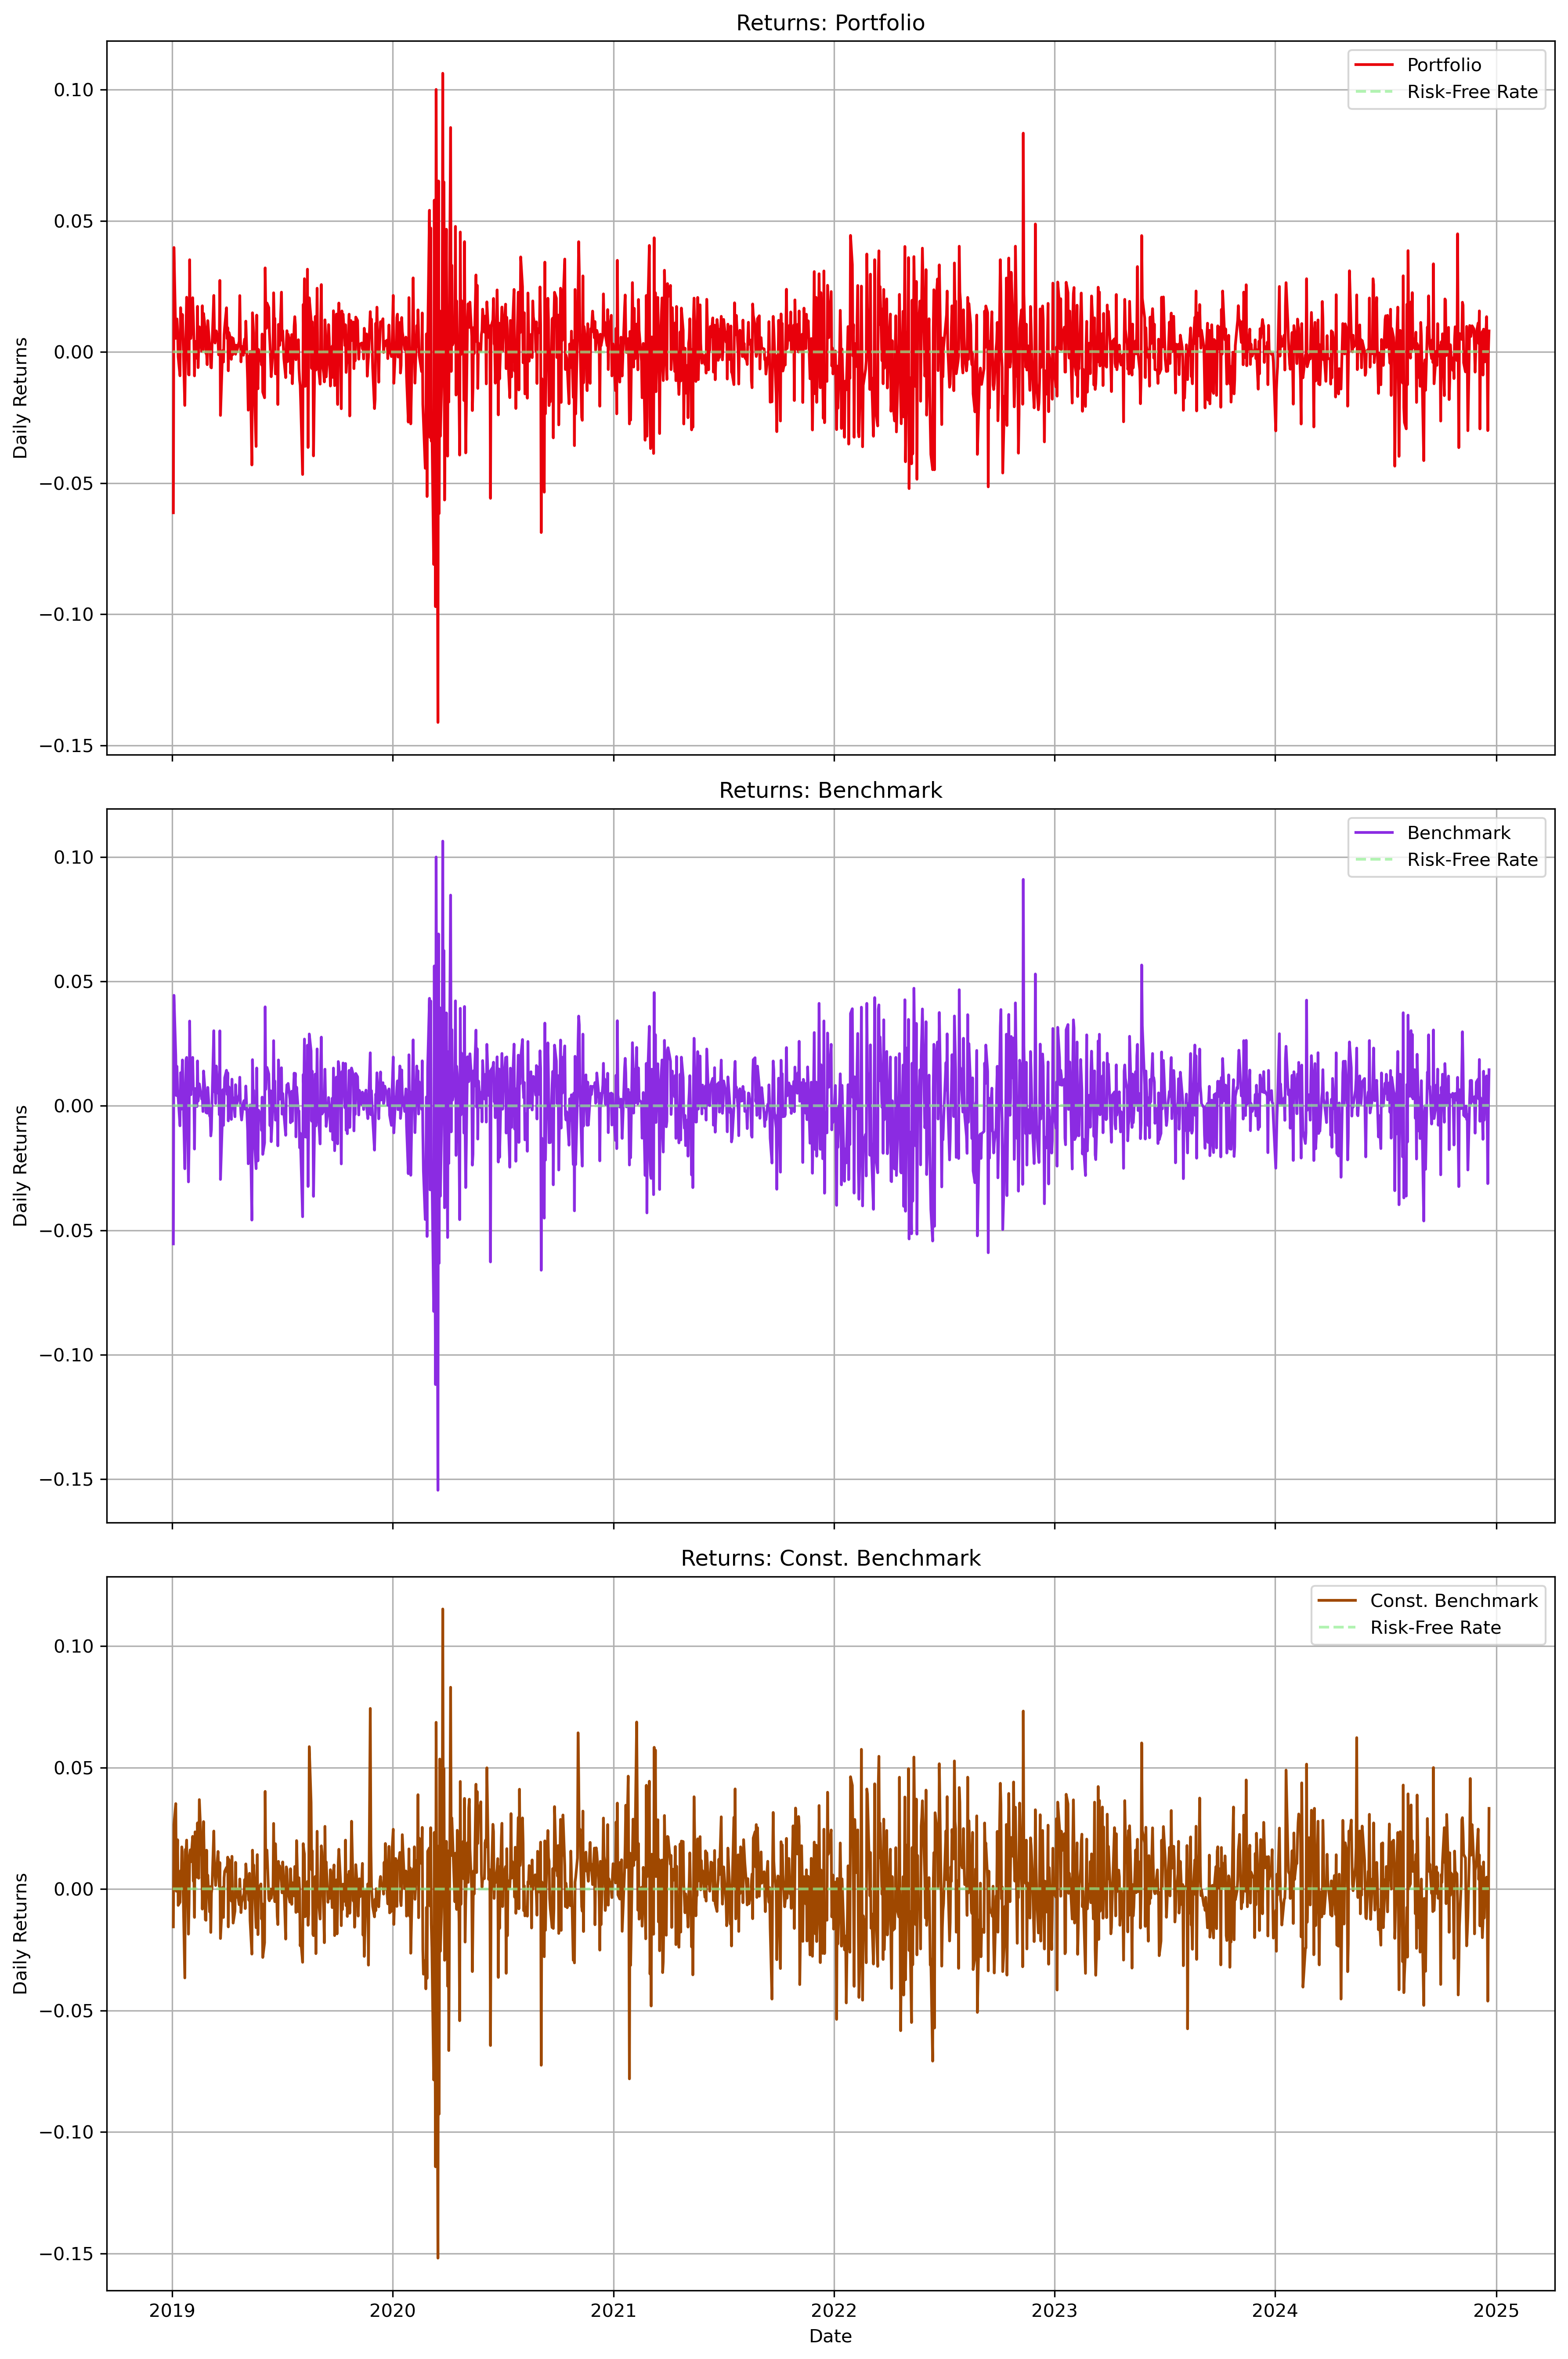

In [72]:

# Define color palettes
num_colors = len(log_pf_stats.columns)
log_pf_palette = sns.color_palette("bright", num_colors * 2)[-num_colors:]

# Create subplots
fig, axes = plt.subplots(nrows=len(log_pf_stats.columns), ncols = 1, figsize = (12, 6 * len(log_pf_stats.columns)), dpi = 300, sharex = True)

# If there's only one column, axes is iterable
if len(log_pf_stats.columns) == 1:
    axes = [axes]

# Plot each portfolio in subplot
for i, col in enumerate(log_pf_stats.columns):
    ax = axes[i]
    
    # Portfolio returns
    ax.plot(log_pf_stats.index, log_pf_stats[col], label = col, color = log_pf_palette[i])
    
    # Risk-free rate (dashed line)
    ax.plot(d_rfr.index, d_rfr['MT RFR (log)'], linestyle = 'dashed', color = 'lightgreen', alpha = 0.7, label = 'Risk-Free Rate')
    
    # Formatting
    ax.set_title(f'Returns: {col}')
    ax.set_ylabel('Daily Returns')
    ax.legend()
    ax.grid(True)

# Set common x-label
plt.xlabel('Date')

plt.tight_layout()
plt.savefig('Portfolio & Benchmark Log Returns.png')

plt.show()


In [73]:
# GARCH Modelling
"""
GARCH Models
"""

# Fit GARCH(1,1) model – portfolio
garch_model_pf = arch_model(log_pf_stats['Portfolio'], vol = 'Garch', p=1, q=1, rescale = False)
garch_res_pf = garch_model_pf.fit(disp = 'off')

# Print model summary
print('GARCH Model – Portfolio\n')
print(garch_res_pf.summary())



# Fit GARCH(1,1) model – benchmark
garch_model_bm = arch_model(log_pf_stats['Benchmark'], vol = 'Garch', p=1, q=1, rescale = False)
garch_res_bm = garch_model_bm.fit(disp = 'off')

# Print model summary
print('\n\nGARCH Model – Benchmark\n')
print(garch_res_bm.summary())



# Fit GARCH(1,1) model – constrained benchmark
garch_model_cbm = arch_model(log_pf_stats['Const. Benchmark'], vol = 'Garch', p=1, q=1, rescale = False)
garch_res_cbm = garch_model_cbm.fit(disp = 'off')

# Print model summary
print('\n\nGARCH Model – Constrained Benchmark\n')
print(garch_res_cbm.summary())


GARCH Model – Portfolio

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4156.48
Distribution:                  Normal   AIC:                          -8304.96
Method:            Maximum Likelihood   BIC:                          -8283.70
                                        No. Observations:                 1503
Date:                Sun, Mar 23 2025   Df Residuals:                     1502
Time:                        22:00:19   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.4765e-03  1.001e-05 

### 5 – Risk-Adjusted Returns

#### 5.1 – Expected Risk-Adjusted Returns

*(Portfolio & Benchmark)*

In [76]:
# Expected Risk-Adjusted Returns
    # Using GARCH results

# Extract expected return (mu) from GARCH models
er_pf = garch_res_pf.params['mu']
er_bm = garch_res_bm.params['mu']
er_cbm = garch_res_cbm.params['mu']

# Annualise expected returns
aer_pf = (er_pf * 252) * 100 # 252 trading days, convert to percentage
aer_bm = (er_bm * 252) * 100
aer_cbm = (er_cbm * 252) * 100

# Print results
print(f'Expected Annualised Returns:') 
print(f'– Portfolio: {aer_pf:.2f}%')
print(f'– Benchmark Index: {aer_bm:.2f}%')
print(f'– Constrained Benchmark: {aer_cbm:.2f}%')


Expected Annualised Returns:
– Portfolio: 37.21%
– Benchmark Index: 43.14%
– Constrained Benchmark: 60.86%


#### 5.2 – Efficient Frontier & Tangency Portfolio

##### 5.2.1 – Set-up

In [79]:
# Portfolio Performance Functions

t_days = 252
exp_ret = alpha_pf.mean() * t_days
er_cov_mx = alpha_pf.cov() * t_days
rfr = mt_rfr

# Return & volatility
def portStats(weights):
    weights = np.array(weights)
    ret = np.dot(weights, exp_ret)  # expected return
    vol = np.sqrt(np.dot(weights.T, np.dot(er_cov_mx, weights)))  # volatility
    return ret, vol

# Negative Sharpe Ratio (for minimisation)
def negSharpe(weights):
    ret, vol = portStats(weights)
    return -(ret - rfr) / vol  # minimise negative sharpe Ratio

# Constraint – sum of weights must be 1
def wCon(weights):
    return np.sum(weights) - 1
    

In [80]:
# Set Parameters

t_days = 252
exp_ret = alpha_pf.mean() * t_days # set to (15) portfolio assets 
er_cov_mx = alpha_pf.cov() * t_days
rfr = mt_rfr # medium-term risk-free rate


In [81]:
# Portfolio Performance Functions

# Return & volatility
def portStats(weights):
    weights = np.array(weights)
    ret = np.dot(weights, exp_ret)  # expected return
    vol = np.sqrt(np.dot(weights.T, np.dot(er_cov_mx, weights)))  # volatility
    return ret, vol

# Negative Sharpe Ratio (for minimisation)
def negSharpe(weights, rfr = rfr): # default to above variable
    ret, vol = portStats(weights)
    return -(ret - rfr) / vol  # minimise negative sharpe Ratio

# Constraint – sum of weights must be 1
def wCon(weights):
    return np.sum(weights) - 1
    

##### 5.2.2 – Run on Portfolio Assets

In [83]:
# Find Tangency Portfolio

num_assets = len(exp_ret)
init_guess = np.ones(num_assets) / num_assets  # equal weights as initial guess
bounds = tuple((0, 1) for _ in range(num_assets))  # no short-selling

# Optimise for max Sharpe Ratio
opt_res = sco.minimize(negSharpe,
                       init_guess,
                       method = 'SLSQP',
                       bounds = bounds,
                       constraints = {'type': 'eq', 'fun': wCon}
                      )

# Extract optimal weights & stats
tan_weights = opt_res.x
tan_ret, tan_vol = portStats(tan_weights)


In [84]:
# Monte Carlo Sim for Efficient Frontier

num_runs = 10_000  # number of portfolios to simulate
pf_rets = []
pf_vols = []

for _ in range(num_runs):
    weights = np.random.dirichlet(np.ones(num_assets), size = 1)[0]  # random weights
    ret, vol = portStats(weights)

    pf_rets.append(ret)
    pf_vols.append(vol)

# Convert to DataFrame
mc_pfs = pd.DataFrame({'Return': pf_rets, 'Volatility': pf_vols})


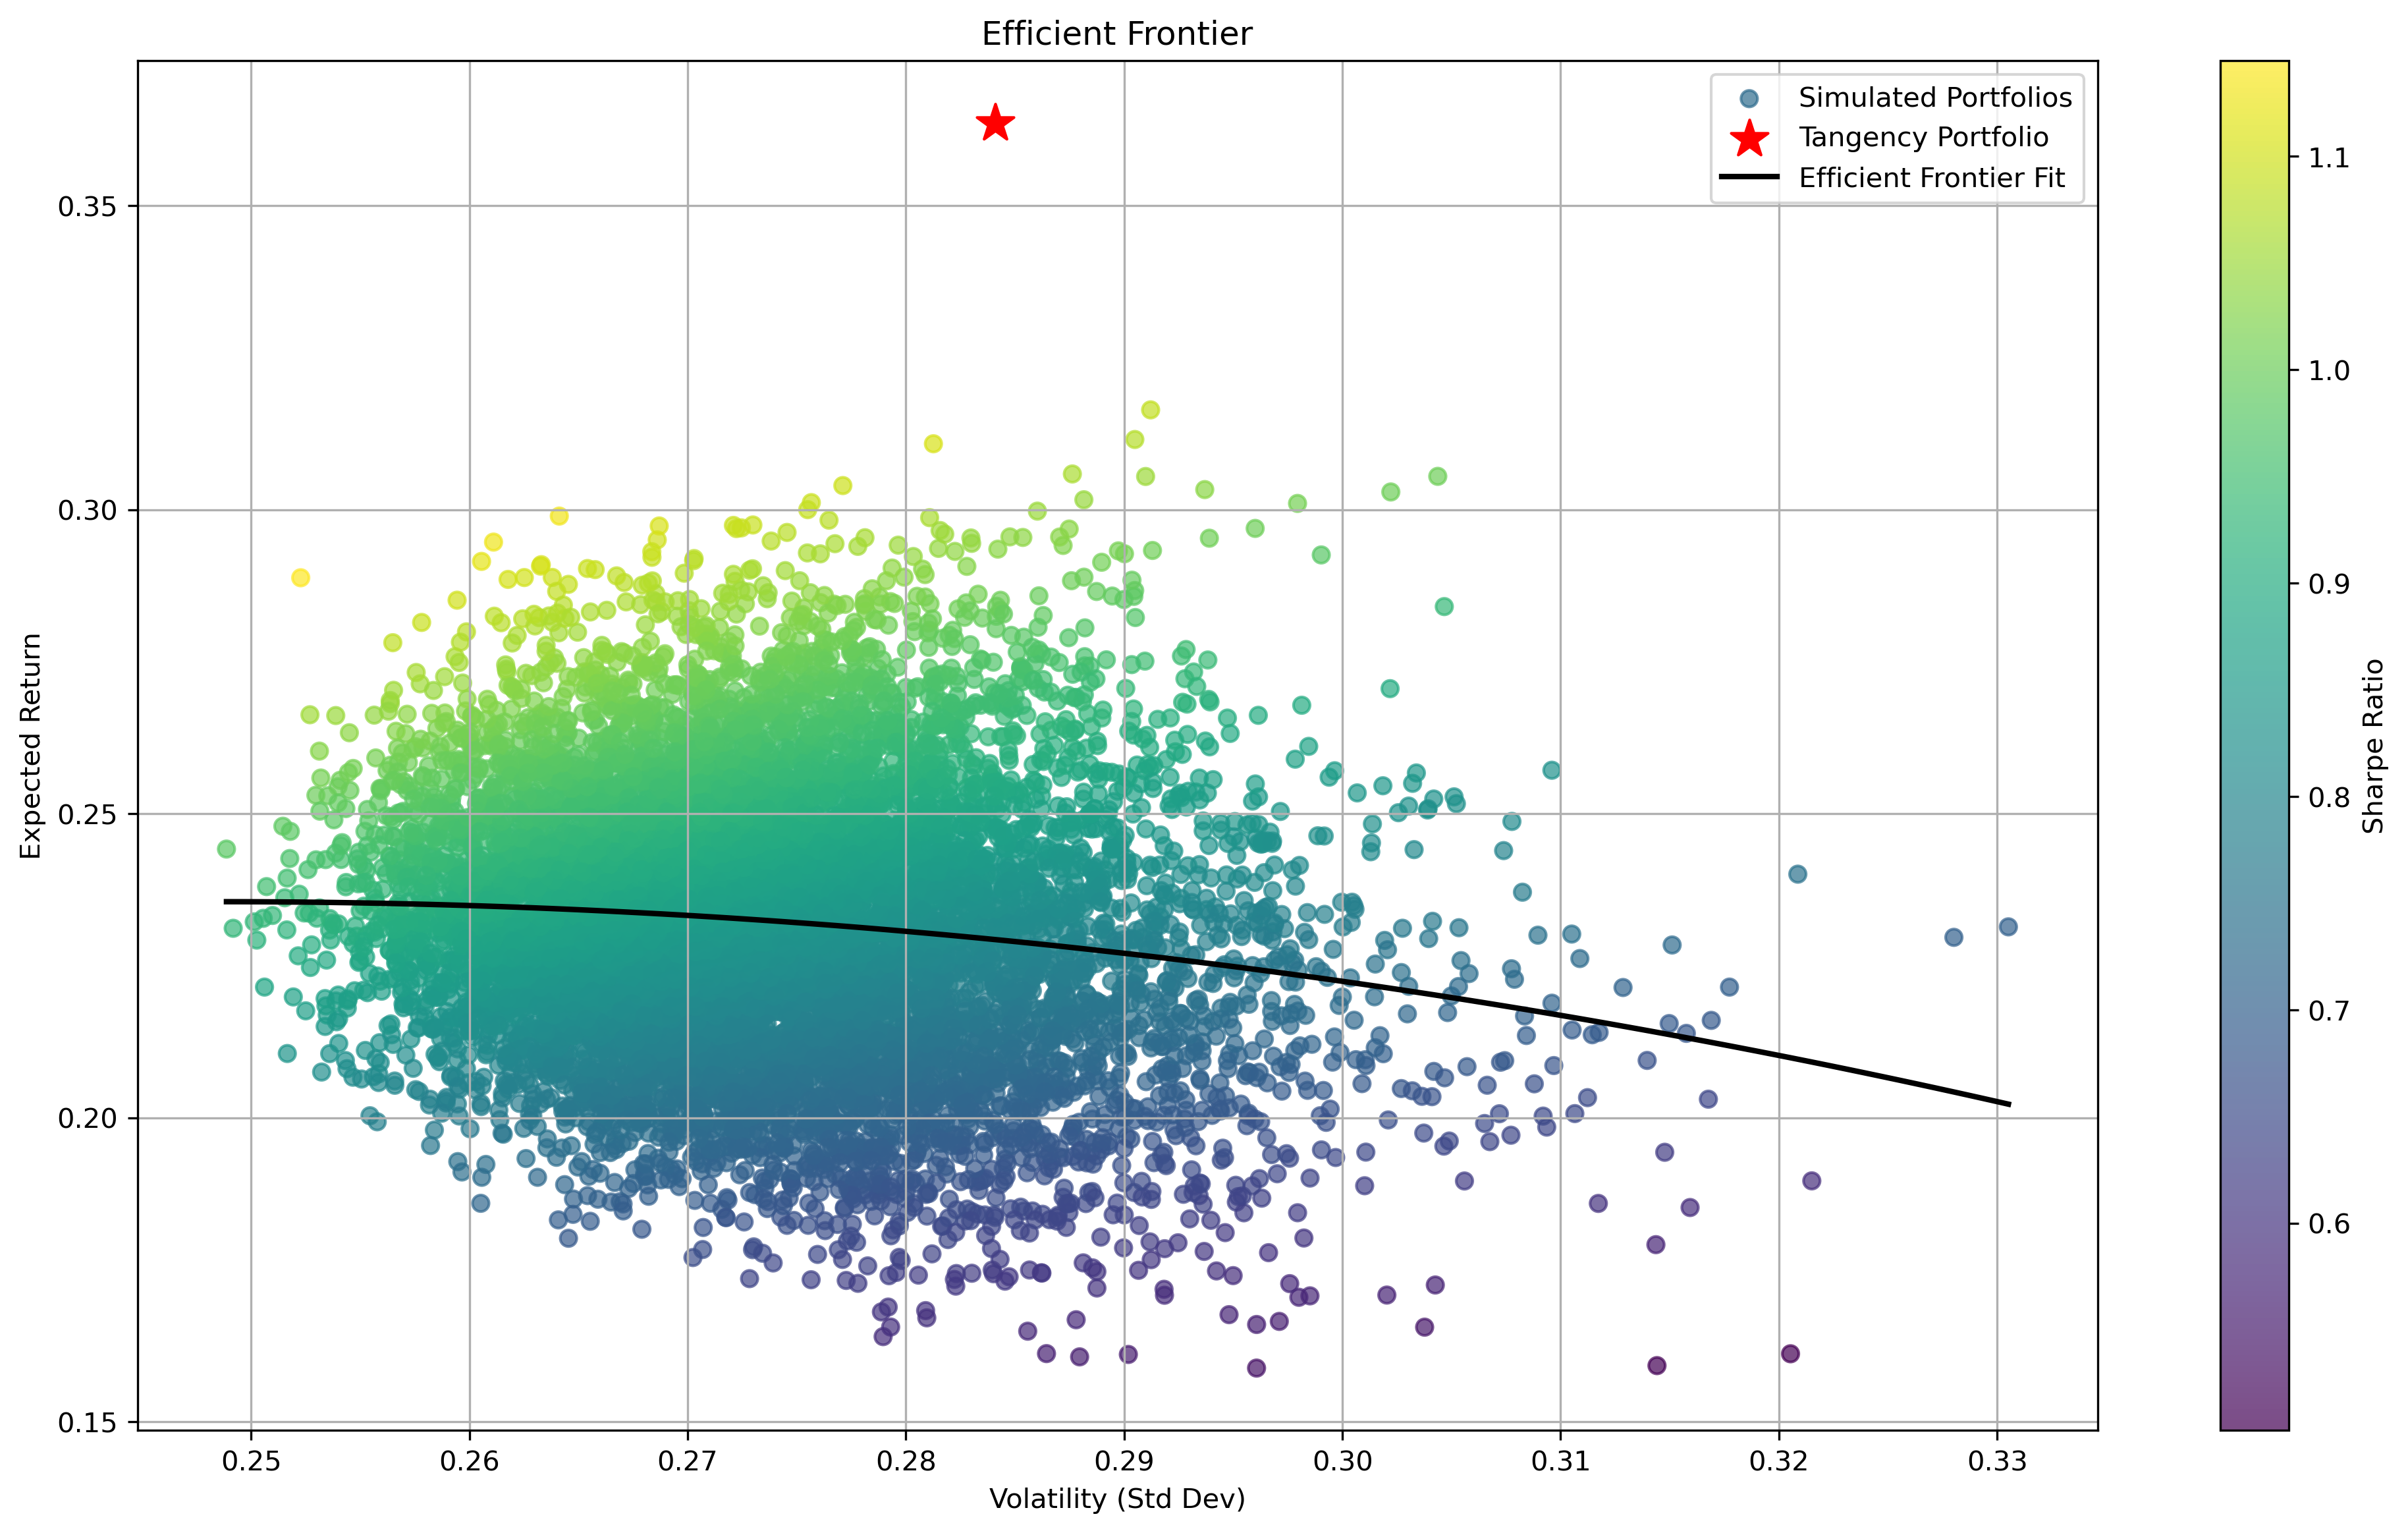

In [85]:
# Plot Efficient Frotnier w/ Tangency Portfolio
"""
Efficient frontier with best fit line
Calculated with monte carlo simulation (10,000 runs)
Tengency portfolio – red star (seems... not right)
Colour mapped based on sharpe ratio
"""

# Fit a polynomial regression (quadratic) to the efficient frontier
pf_vols_sorted, pf_rets_sorted = zip(*sorted(zip(mc_pfs['Volatility'], mc_pfs['Return'])))
poly_coeffs = np.polyfit(pf_vols_sorted, pf_rets_sorted, deg=2)  # Quadratic fit
poly_fit = np.poly1d(poly_coeffs)

# Generate smooth curve
vol_range = np.linspace(min(pf_vols_sorted), max(pf_vols_sorted), 100)
fit_returns = poly_fit(vol_range)

# Plot efficient frontier w/ best-fit line
plt.figure(figsize = (16,9), dpi = 300)
plt.scatter(mc_pfs['Volatility'], mc_pfs['Return'], c = mc_pfs['Return']/mc_pfs['Volatility'],
            cmap = 'viridis', alpha = 0.7, label = 'Simulated Portfolios')
plt.colorbar(label = 'Sharpe Ratio')

# Plot tangency portfolio
plt.scatter(tan_vol, tan_ret, color = 'red', marker = '*', s = 200, label = 'Tangency Portfolio')

# Plot best-fit line for efficient frontier
plt.plot(vol_range, fit_returns, color = 'black', linewidth = 2, label = 'Efficient Frontier Fit')

plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.legend()
plt.grid(True)

plt.savefig('Efficient Frontier.png')
plt.show()
